In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.animation as animation
import datetime
import seaborn as sns
import missingno as msno
import firebase_admin
from firebase_admin import credentials, db
from datetime import datetime  # Untuk konversi timestamp ke human-readable
sns.set_theme(style="whitegrid")
%matplotlib inline 

In [2]:
# Konfigurasi database sumber
source_cred = credentials.Certificate("D:/staklimjerukagung-firebase-adminsdk-kcfma-e091165a9b.json")
firebase_admin.initialize_app(source_cred, {
    'databaseURL': 'https://staklimjerukagung-default-rtdb.asia-southeast1.firebasedatabase.app/'
})

In [3]:
# Input readable date
start_readable_date = "01-11-2025 00:00:00"  # Format: DD-MM-YYYY HH:MM:SS
end_readable_date = "30-11-2025 23:59:59"  # Format: DD-MM-YYYY HH:MM:SS

# Convert readable date to Unix timestamp
start_timestamp = int(datetime.strptime(start_readable_date, "%d-%m-%Y %H:%M:%S").timestamp())
print(start_timestamp) # Convert to string and print
end_timestamp = int(datetime.strptime(end_readable_date, "%d-%m-%Y %H:%M:%S").timestamp())
print(end_timestamp) # Convert to string and print


1761930000
1764521999


In [4]:
def fetch_weather_data(station_id, start_ts, end_ts):
    """
    Mengambil data cuaca dari Firebase Realtime Database untuk stasiun dan rentang waktu tertentu.

    Args:
        station_id (str): ID stasiun cuaca (contoh: 'id-03', 'id-04').
        start_ts (int): Timestamp awal (epoch time).
        end_ts (int): Timestamp akhir (epoch time).

    Returns:
        dict: Hasil data dari Firebase, atau None jika tidak ada data.
    """
    try:
        # Membuat path referensi secara dinamis berdasarkan station_id
        ref_path = f'/auto_weather_stat/{station_id}/data'
        ref_data = db.reference(ref_path)

        # Membuat query dengan rentang waktu
        query_data = ref_data.order_by_key().start_at(str(start_ts)).end_at(str(end_ts))

        # Mengambil dan mengembalikan hasil
        results = query_data.get()
        print(f"Data untuk stasiun {station_id} berhasil diambil.")
        return results
    except Exception as e:
        print(f"Terjadi error saat mengambil data untuk {station_id}: {e}")
        return None

# 2. Siapkan daftar ID stasiun yang ingin diambil datanya
station_ids = ['id-03', 'id-05'] # Mudah untuk menambah stasiun baru

# 3. Gunakan loop untuk mengambil data semua stasiun dan simpan hasilnya
all_weather_data = {}
for station in station_ids:
    # Panggil fungsi untuk setiap stasiun
    data = fetch_weather_data(station, start_timestamp, end_timestamp)
    if data:
        all_weather_data[station] = data

Data untuk stasiun id-03 berhasil diambil.
Data untuk stasiun id-05 berhasil diambil.


In [5]:
def create_weather_dataframe(data_dict, source_name):
    """
    Mengubah dictionary data cuaca menjadi DataFrame Pandas.

    Args:
        data_dict (dict): Dictionary berisi data cuaca yang diambil dari Firebase.
        source_name (str): Nama atau ID sumber data untuk keperluan logging/print.

    Returns:
        pandas.DataFrame: DataFrame yang sudah diformat, atau None jika input kosong.
    """
    # Periksa apakah ada data untuk diproses
    if not data_dict:
        print(f"Tidak ada data dari sumber '{source_name}' untuk diproses.")
        return None

    try:
        # Mengubah data dari dictionary menjadi DataFrame
        # 'orient="index"' menjadikan key dari dictionary sebagai baris awal
        df = pd.DataFrame.from_dict(data_dict, orient='index')

        # Memastikan kolom 'timestamp' ada.
        # Jika 'timestamp' bukan salah satu kolom, berarti ia adalah indeks.
        if 'timestamp' not in df.columns:
            df.index.name = 'timestamp'  # Beri nama pada indeks
            df.reset_index(inplace=True) # Pindahkan indeks menjadi kolom biasa

        print(f"DataFrame untuk sumber '{source_name}' berhasil dibuat.")
        return df
        
    except Exception as e:
        print(f"Gagal membuat DataFrame untuk '{source_name}': {e}")
        return None


# 2. Siapkan dictionary kosong untuk menampung DataFrame yang akan kita buat
weather_dataframes = {}

# 3. Loop melalui setiap item di all_weather_data
#    Gunakan .items() untuk mendapatkan key (nama stasiun) dan value (datanya)
for station_id, raw_data in all_weather_data.items():
    
    # Panggil fungsi baru kita untuk mengubah data mentah menjadi DataFrame
    df = create_weather_dataframe(raw_data, station_id)
    
    # Jika DataFrame berhasil dibuat, simpan ke dalam dictionary kita
    if df is not None:
        weather_dataframes[station_id] = df

# 4. Sekarang semua DataFrame Anda tersimpan rapi di satu tempat
print("\n--- Verifikasi Hasil ---")

DataFrame untuk sumber 'id-03' berhasil dibuat.
DataFrame untuk sumber 'id-05' berhasil dibuat.

--- Verifikasi Hasil ---


In [6]:
def save_weather_data_to_csv(data_dict, output_folder='analisis'):
    """
    Menyimpan setiap DataFrame dalam dictionary ke file CSV terpisah.

    Args:
        data_dict (dict): Dictionary berisi {station_id: DataFrame}.
        output_folder (str): Nama folder untuk menyimpan file CSV.
    """
    # Pastikan modul os terimport (biasanya sudah di cell paling atas, tapi untuk keamanan)
    import os

    # Buat folder jika belum ada
    if not os.path.exists(output_folder):
        try:
            os.makedirs(output_folder)
            print(f"Folder '{output_folder}' berhasil dibuat.")
        except OSError as e:
            print(f"Gagal membuat folder '{output_folder}': {e}")
            return

    print(f"\n--- Menyimpan Data ke Folder '{output_folder}' ---")

    for station_id, df in data_dict.items():
        try:
            # Buat nama file yang aman
            filename = f"meteo_data_{station_id}.csv"
            file_path = os.path.join(output_folder, filename)

            # Simpan ke CSV
            # index=False karena timestamp biasanya sudah di-reset menjadi kolom di langkah sebelumnya
            df.to_csv(file_path, index=False)
            print(f"Berhasil menyimpan: {filename}")
        except Exception as e:
            print(f"Gagal menyimpan data untuk {station_id}: {e}")

# Panggil fungsi untuk menyimpan data
save_weather_data_to_csv(weather_dataframes)


--- Menyimpan Data ke Folder 'analisis' ---
Berhasil menyimpan: meteo_data_id-03.csv
Berhasil menyimpan: meteo_data_id-05.csv


In [7]:
def load_weather_data_from_csv(input_folder='analisis'):
    """
    Membaca kembali file CSV dari folder ke dalam dictionary DataFrame.

    Args:
        input_folder (str): Nama folder tempat file CSV disimpan.

    Returns:
        dict: Dictionary berisi {station_id: DataFrame}.
    """
    import os
    import pandas as pd

    loaded_data = {}

    # Cek apakah folder ada
    if not os.path.exists(input_folder):
        print(f"Folder '{input_folder}' tidak ditemukan.")
        return loaded_data

    print(f"\n--- Membaca Data dari Folder '{input_folder}' ---")

    try:
        # Loop semua file di folder
        for filename in os.listdir(input_folder):
            if filename.endswith(".csv") and filename.startswith("meteo_data_"):
                # Ekstrak station_id dari nama file (meteo_data_id-03.csv -> id-03)
                station_id = filename.replace("meteo_data_", "").replace(".csv", "")
                
                file_path = os.path.join(input_folder, filename)
                
                # Baca CSV ke DataFrame
                df = pd.read_csv(file_path)
                
                # Simpan ke dictionary
                loaded_data[station_id] = df
                print(f"Berhasil memuat: {station_id} ({len(df)} baris)")
                
        return loaded_data

    except Exception as e:
        print(f"Terjadi kesalahan saat membaca data: {e}")
        return {}


# Uncomment baris di bawah ini jika ingin me-load data dari CSV menggantikan data dari API
weather_dataframes = load_weather_data_from_csv()


--- Membaca Data dari Folder 'analisis' ---
Berhasil memuat: id-03 (41123 baris)
Berhasil memuat: id-05 (40543 baris)


In [8]:
if 'id-03' in weather_dataframes:
    print("\nMenampilkan data dari DataFrame 'id-03':")
    print(weather_dataframes['id-03'].tail(10))
if 'id-04' in weather_dataframes:
    print("\nMenampilkan data dari DataFrame 'id-04':")
    print(weather_dataframes['id-04'].tail(10))
if 'id-05' in weather_dataframes:
    print("\nMenampilkan data dari DataFrame 'id-05':")
    print(weather_dataframes['id-05'].tail(10))


Menampilkan data dari DataFrame 'id-03':
            dew  humidity  pressure  temperature   timestamp  volt  rainfall  \
41113  24.68788     90.12   1011.47        26.44  1764425071  4.09       NaN   
41114  24.71876     90.18   1011.48        26.46  1764425131  4.09       NaN   
41115  24.75399     90.37   1011.48        26.46  1764425191  4.10       NaN   
41116  24.73980     90.40   1011.45        26.44  1764425251  4.09       NaN   
41117  24.73425     90.37   1011.49        26.44  1764425311  4.10       NaN   
41118  24.73733     90.44   1011.49        26.43  1764425371  4.10       NaN   
41119  24.78546     90.54   1011.48        26.46  1764425431  4.10       NaN   
41120  24.78853     90.61   1011.43        26.45  1764425491  4.10       NaN   
41121  24.83717     90.82   1011.47        26.46  1764425551  4.10       NaN   
41122  24.85561     90.92   1011.46        26.46  1764425612  4.10       NaN   

       rainrate  
41113       NaN  
41114       NaN  
41115       NaN  
41116

In [9]:
weather_dataframes['id-03'].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41123 entries, 0 to 41122
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   dew          41123 non-null  float64
 1   humidity     41123 non-null  float64
 2   pressure     41123 non-null  float64
 3   temperature  41123 non-null  float64
 4   timestamp    41123 non-null  int64  
 5   volt         41123 non-null  float64
 6   rainfall     1 non-null      float64
 7   rainrate     1 non-null      float64
dtypes: float64(7), int64(1)
memory usage: 2.5 MB


In [10]:
weather_dataframes['id-05'].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40543 entries, 0 to 40542
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   dew          40543 non-null  float64
 1   humidity     40543 non-null  float64
 2   pressure     40543 non-null  float64
 3   rainfall     40543 non-null  float64
 4   rainrate     40543 non-null  float64
 5   temperature  40543 non-null  float64
 6   timestamp    40543 non-null  int64  
 7   volt         40266 non-null  float64
dtypes: float64(7), int64(1)
memory usage: 2.5 MB


In [11]:
def convert_timestamp_to_int(df, column_name='timestamp'):
    """
    Mengubah tipe data kolom tertentu dalam DataFrame menjadi integer.

    Args:
        df (pd.DataFrame): DataFrame yang akan dimodifikasi.
        column_name (str): Nama kolom yang akan diubah tipenya. Defaultnya adalah 'timestamp'.

    Returns:
        pd.DataFrame: DataFrame yang telah dimodifikasi, atau DataFrame asli jika kolom tidak ditemukan.
    """
    # Periksa apakah input adalah DataFrame yang valid dan memiliki kolom yang dimaksud
    if isinstance(df, pd.DataFrame) and column_name in df.columns:
        try:
            df[column_name] = df[column_name].astype(int)
            print(f"Kolom '{column_name}' berhasil diubah menjadi tipe integer.")
        except Exception as e:
            print(f"Gagal mengubah tipe data kolom '{column_name}': {e}")
    else:
        # Memberi tahu pengguna jika kolom tidak ada di DataFrame
        print(f"Peringatan: Kolom '{column_name}' tidak ditemukan dalam DataFrame.")
        
    return df



In [12]:
# Loop melalui setiap DataFrame dan terapkan fungsi konversi
for station_id in weather_dataframes:
    print(f"Memproses DataFrame untuk stasiun: {station_id}")
    weather_dataframes[station_id] = convert_timestamp_to_int(weather_dataframes[station_id])

print("\n--- Memeriksa tipe data SETELAH konversi ---")

Memproses DataFrame untuk stasiun: id-03
Kolom 'timestamp' berhasil diubah menjadi tipe integer.
Memproses DataFrame untuk stasiun: id-05
Kolom 'timestamp' berhasil diubah menjadi tipe integer.

--- Memeriksa tipe data SETELAH konversi ---


In [13]:
def format_datetime_column(df, column_name='timestamp', target_tz='UTC'):
    """
    Mengonversi kolom timestamp (integer) ke datetime dengan zona waktu tertentu.

    Proses:
    1. Mengubah integer timestamp (detik) menjadi datetime dalam UTC.
    2. Mengonversi datetime dari UTC ke zona waktu target (default: 'Asia/Jakarta').

    Args:
        df (pd.DataFrame): DataFrame yang akan diproses.
        column_name (str): Nama kolom timestamp. Defaultnya 'timestamp'.
        target_tz (str): Zona waktu target. Defaultnya 'Asia/Jakarta'.

    Returns:
        pd.DataFrame: DataFrame yang telah dimodifikasi.
    """
    # Pastikan input adalah DataFrame dan kolomnya ada
    if not isinstance(df, pd.DataFrame) or column_name not in df.columns:
        print(f"Peringatan: Input bukan DataFrame atau kolom '{column_name}' tidak ditemukan.")
        return df

    try:
        # Langkah 1: Konversi dari integer (epoch seconds) ke datetime UTC
        df[column_name] = pd.to_datetime(df[column_name], unit='s', utc=True)
        
        # Langkah 2: Konversi zona waktu dari UTC ke target_tz (WIB)
        df[column_name] = df[column_name].dt.tz_convert(target_tz)
        
        print(f"Kolom '{column_name}' berhasil diformat ke zona waktu {target_tz}.")
    except Exception as e:
        print(f"Gagal memformat kolom '{column_name}': {e}")
        
    return df

In [14]:
for station_id in weather_dataframes:
    print(f"Memproses DataFrame untuk stasiun: {station_id}")
    weather_dataframes[station_id] = format_datetime_column(weather_dataframes[station_id])

Memproses DataFrame untuk stasiun: id-03
Kolom 'timestamp' berhasil diformat ke zona waktu UTC.
Memproses DataFrame untuk stasiun: id-05
Kolom 'timestamp' berhasil diformat ke zona waktu UTC.


In [15]:
def add_time_features(df, column_name='timestamp'):
    """
    Menambahkan kolom-kolom berbasis waktu (jam, hari, bulan, dll.) ke DataFrame.

    Proses:
    1. Memastikan kolom waktu berformat datetime.
    2. Mengurutkan DataFrame berdasarkan kolom waktu tersebut.
    3. Mengekstrak dan menambahkan kolom 'hour', 'minute', 'day', 'week', 'month', dan 'year'.

    Args:
        df (pd.DataFrame): DataFrame input.
        column_name (str): Nama kolom datetime yang akan diproses.

    Returns:
        pd.DataFrame: DataFrame baru dengan kolom-kolom waktu tambahan.
    """
    if not isinstance(df, pd.DataFrame) or column_name not in df.columns:
        print(f"Peringatan: Input bukan DataFrame atau kolom '{column_name}' tidak ditemukan.")
        return df

    try:
        # Langkah 1: Memastikan kolom 'timestamp' berformat datetime (sebagai pengaman)
        df[column_name] = pd.to_datetime(df[column_name])

        # Langkah 2: Mengurutkan data berdasarkan 'timestamp'
        df = df.sort_values(by=column_name)

        # Langkah 3: Menambahkan kolom-kolom waktu
        df['hour'] = df[column_name].dt.hour
        df['minute'] = df[column_name].dt.minute
        df['day'] = df[column_name].dt.day
        df['week'] = df[column_name].dt.isocalendar().week.astype(int) # .isocalendar() menghasilkan object kompleks
        df['month'] = df[column_name].dt.month
        df['year'] = df[column_name].dt.year
        
        print(f"Fitur waktu berhasil ditambahkan ke DataFrame.")
    except Exception as e:
        print(f"Gagal menambahkan fitur waktu: {e}")
        
    return df

In [16]:
for station_id in weather_dataframes:
    print(f"--- Memproses DataFrame untuk stasiun: {station_id} ---")
    weather_dataframes[station_id] = add_time_features(weather_dataframes[station_id])

print("\n" + "="*50 + "\n")

# Verifikasi hasil dari dictionary
print("Hasil akhir untuk 'id-05' dari dictionary:")
print(weather_dataframes['id-05'].tail(10))

--- Memproses DataFrame untuk stasiun: id-03 ---
Fitur waktu berhasil ditambahkan ke DataFrame.
--- Memproses DataFrame untuk stasiun: id-05 ---
Fitur waktu berhasil ditambahkan ke DataFrame.


Hasil akhir untuk 'id-05' dari dictionary:
            dew  humidity  pressure  rainfall  rainrate  temperature  \
40533  25.00944  88.45525   1012.39       0.0       0.0     27.08820   
40534  25.04368  88.60784   1012.38       0.0       0.0     27.09354   
40535  25.03027  88.59258   1012.40       0.0       0.0     27.08286   
40536  25.04450  88.59830   1012.41       0.0       0.0     27.09621   
40537  25.03263  88.57732   1012.39       0.0       0.0     27.08820   
40538  25.03065  88.48386   1012.38       0.0       0.0     27.10422   
40539  25.04334  88.49531   1012.39       0.0       0.0     27.11490   
40540  25.05960  88.69176   1012.39       0.0       0.0     27.09354   
40541  25.13653  88.90349   1012.40       0.0       0.0     27.13092   
40542  25.19496  89.25445   1012.40       0

In [65]:
# Mengekstrak setiap DataFrame ke variabel terpisah
cuaca3 = weather_dataframes['id-03']
#cuaca4 = weather_dataframes['id-04']
cuaca5 = weather_dataframes['id-05']

In [66]:
cuaca5.tail(50)

dew  humidity  pressure  rainfall  rainrate  temperature  \
40493  25.15155  87.14107   1012.30       0.0       0.0     27.48875   
40494  25.13046  87.05905   1012.33       0.0       0.0     27.48341   
40495  25.09673  86.93889   1012.35       0.0       0.0     27.47272   
40496  25.09037  87.05524   1012.34       0.0       0.0     27.44335   
40497  25.10845  87.02663   1012.36       0.0       0.0     27.46738   
40498  25.05985  86.99229   1012.35       0.0       0.0     27.42466   
40499  25.04870  86.96178   1012.31       0.0       0.0     27.41932   
40500  25.08798  87.49203   1012.32       0.0       0.0     27.35523   
40501  25.07022  87.34516   1012.31       0.0       0.0     27.36591   
40502  25.07387  87.70565   1012.36       0.0       0.0     27.29916   
40503  25.10093  87.84680   1012.35       0.0       0.0     27.29916   
40504  25.03695  87.58167   1012.36       0.0       0.0     27.28580   
40505  25.06256  87.86588   1012.35       0.0       0.0     27.25643   
40506  25.03985  87.82964   1012.33       0.0       0.0     27.24040   
40507  25.01812  87.82582   1012.34       0.0       0.0     27.21904   
40508  25.04941  88.00320   1012.32       0.0       0.0     27.21637   
40509  25.02440  87.91356   1012.35       0.0       0.0     27.20836   
40510  25.01415  88.06615   1012.32       0.0       0.0     27.16830   
40511  25.05498  88.26643   1012.33       0.0       0.0     27.17097   
40512  25.04273  88.24353   1012.34       0.0       0.0     27.16296   
40513  25.02006  88.20729   1012.34       0.0       0.0     27.14694   
40514  24.97555  88.05661   1012.35       0.0       0.0     27.13092   
40515  24.96268  87.87923   1012.38       0.0       0.0     27.15228   
40516  24.95385  87.84680   1012.35       0.0       0.0     27.14961   
40517  24.95501  87.97650   1012.35       0.0       0.0     27.12558   
40518  24.94788  88.10429   1012.34       0.0       0.0     27.09354   
40519  24.94257  88.04898   1012.38       0.0       0.0     27.09888   
40520  24.95126  88.03944   1012.36       0.0       0.0     27.10956   
40521  24.95845  88.21492   1012.33       0.0       0.0     27.08286   
40522  24.96994  88.17868   1012.36       0.0       0.0     27.10155   
40523  24.95191  88.05661   1012.36       0.0       0.0     27.10689   
40524  24.95313  88.10429   1012.36       0.0       0.0     27.09888   
40525  24.92960  88.02228   1012.32       0.0       0.0     27.09087   
40526  24.95280  88.03372   1012.33       0.0       0.0     27.11223   
40527  24.93698  87.97841   1012.37       0.0       0.0     27.10689   
40528  24.93425  88.06042   1012.35       0.0       0.0     27.08820   
40529  24.94572  88.02419   1012.36       0.0       0.0     27.10689   
40530  24.95825  88.18631   1012.42       0.0       0.0     27.08820   
40531  24.99625  88.23399   1012.37       0.0       0.0     27.11757   
40532  24.98877  88.40185   1012.39       0.0       0.0     27.07751   
40533  25.00944  88.45525   1012.39       0.0       0.0     27.08820   
40534  25.04368  88.60784   1012.38       0.0       0.0     27.09354   
40535  25.03027  88.59258   1012.40       0.0       0.0     27.08286   
40536  25.04450  88.59830   1012.41       0.0       0.0     27.09621   
40537  25.03263  88.57732   1012.39       0.0       0.0     27.08820   
40538  25.03065  88.48386   1012.38       0.0       0.0     27.10422   
40539  25.04334  88.49531   1012.39       0.0       0.0     27.11490   
40540  25.05960  88.69176   1012.39       0.0       0.0     27.09354   
40541  25.13653  88.90349   1012.40       0.0       0.0     27.13092   
40542  25.19496  89.25445   1012.40       0.0       0.0     27.12291   

                      timestamp     volt  hour  minute  day  week  month  year  
40493 2025-11-29 13:25:26+00:00  3.93500    13      25   29    48     11  2025  
40494 2025-11-29 13:26:26+00:00  4.01250    13      26   29    48     11  2025  
40495 2025-11-29 13:27:26+00:00  3.91000    13      27   29    48     11  2025  
40496 2025-11-2

=== Informasi Missing Values dalam cuaca3 ===

dew                0
humidity           0
pressure           0
temperature        0
timestamp          0
volt               0
rainfall       41122
rainrate       41122
hour               0
minute             0
day                0
week               0
month              0
year               0
dtype: int64


=== Persentase Missing Values ===

dew             0.000000
humidity        0.000000
pressure        0.000000
temperature     0.000000
timestamp       0.000000
volt            0.000000
rainfall       99.997568
rainrate       99.997568
hour            0.000000
minute          0.000000
day             0.000000
week            0.000000
month           0.000000
year            0.000000
dtype: float64


=== Visualisasi Missing Values ===


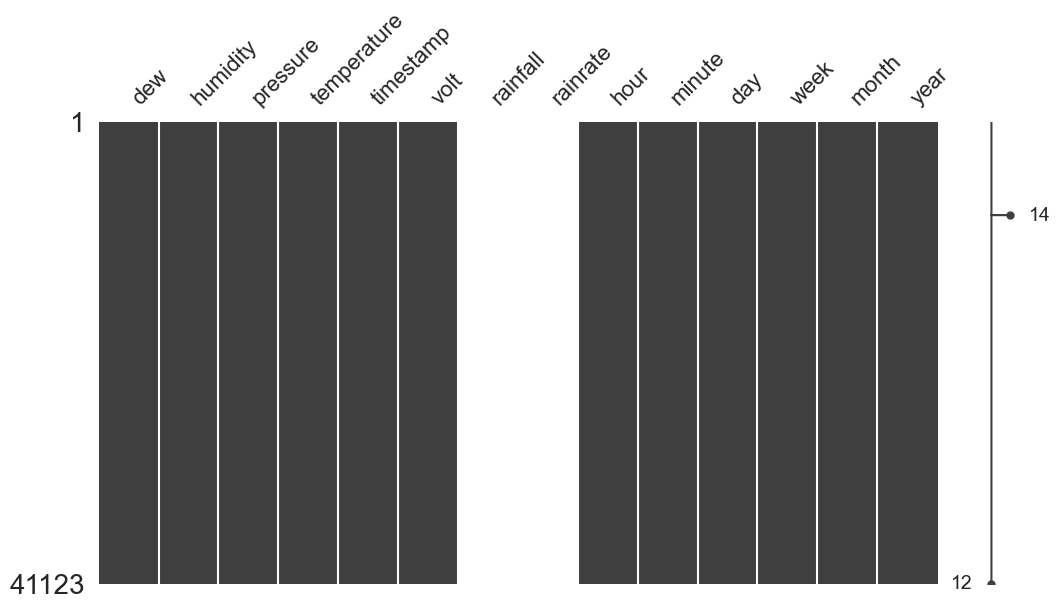


=== Baris dengan Nilai Null ===
Jumlah baris dengan null: 41122

Contoh baris dengan null:
        dew  humidity  pressure  temperature                 timestamp  volt  \
0  24.54409     98.13   1011.90        24.86 2025-10-31 17:00:00+00:00  4.10   
1  24.51076     98.11   1011.88        24.83 2025-10-31 17:01:00+00:00  4.10   
2  24.54409     98.13   1011.88        24.86 2025-10-31 17:02:00+00:00  4.10   
3  24.55577     98.14   1011.87        24.87 2025-10-31 17:03:00+00:00  4.10   
4  24.54750     98.15   1011.84        24.86 2025-10-31 17:04:01+00:00  4.09   
5  24.54750     98.15   1011.85        24.86 2025-10-31 17:05:01+00:00  4.09   
6  24.56404     98.13   1011.80        24.88 2025-10-31 17:06:01+00:00  4.09   
7  24.54093     98.17   1011.79        24.85 2025-10-31 17:07:01+00:00  4.09   
8  24.53923     98.16   1011.78        24.85 2025-10-31 17:08:01+00:00  4.09   
9  24.54750     98.15   1011.82        24.86 2025-10-31 17:09:01+00:00  4.09   

   rainfall  rainrate  hour

In [67]:
# Mengecek nilai null dalam dataframe cuaca3
print("=== Informasi Missing Values dalam cuaca3 ===\n")
print(cuaca3.isnull().sum())
print("\n" + "="*50 + "\n")

# Menampilkan persentase missing values
print("=== Persentase Missing Values ===\n")
missing_percentage = (cuaca3.isnull().sum() / len(cuaca3)) * 100
print(missing_percentage)
print("\n" + "="*50 + "\n")

# Visualisasi missing values menggunakan missingno
print("=== Visualisasi Missing Values ===")
msno.matrix(cuaca3, figsize=(12, 6))
plt.show()

# Menampilkan baris-baris yang mengandung nilai null
print("\n=== Baris dengan Nilai Null ===")
null_rows = cuaca3[cuaca1.isnull().any(axis=1)]
print(f"Jumlah baris dengan null: {len(null_rows)}")
print("\nContoh baris dengan null:")
print(null_rows.head(10))

=== Informasi Missing Values dalam cuaca5 ===

dew              0
humidity         0
pressure         0
rainfall         0
rainrate         0
temperature      0
timestamp        0
volt           277
hour             0
minute           0
day              0
week             0
month            0
year             0
dtype: int64


=== Persentase Missing Values ===

dew            0.000000
humidity       0.000000
pressure       0.000000
rainfall       0.000000
rainrate       0.000000
temperature    0.000000
timestamp      0.000000
volt           0.683225
hour           0.000000
minute         0.000000
day            0.000000
week           0.000000
month          0.000000
year           0.000000
dtype: float64


=== Visualisasi Missing Values ===


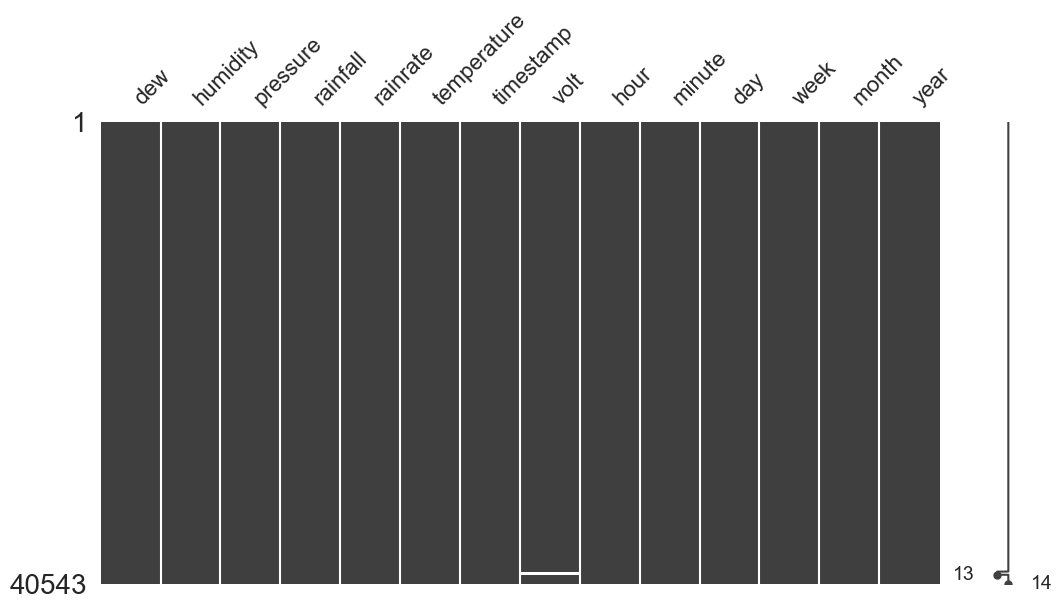


=== Baris dengan Nilai Null ===
Jumlah baris dengan null: 277

Contoh baris dengan null:
         dew  humidity  pressure  rainfall  rainrate  temperature  \
39458  24.40     94.93   1010.22       0.0       0.0        24.50   
39459  24.39     94.93   1010.23       0.0       0.0        24.49   
39460  24.39     94.93   1010.24       0.0       0.0        24.49   
39461  24.38     94.93   1010.24       0.0       0.0        24.48   
39462  24.37     94.93   1010.25       0.0       0.0        24.47   
39463  24.36     94.93   1010.26       0.0       0.0        24.46   
39464  24.36     94.93   1010.26       0.0       0.0        24.46   
39465  24.35     94.93   1010.27       0.0       0.0        24.45   
39466  24.34     94.93   1010.28       0.0       0.0        24.44   
39467  24.33     94.93   1010.28       0.0       0.0        24.43   

                      timestamp  volt  hour  minute  day  week  month  year  
39458 2025-11-28 20:10:00+00:00   NaN    20      10   28    48     11  2

In [68]:
# Mengecek nilai null dalam dataframe cuaca5
print("=== Informasi Missing Values dalam cuaca5 ===\n")
print(cuaca5.isnull().sum())
print("\n" + "="*50 + "\n")

# Menampilkan persentase missing values
print("=== Persentase Missing Values ===\n")
missing_percentage = (cuaca5.isnull().sum() / len(cuaca5)) * 100
print(missing_percentage)
print("\n" + "="*50 + "\n")

# Visualisasi missing values menggunakan missingno
print("=== Visualisasi Missing Values ===")
msno.matrix(cuaca5, figsize=(12, 6))
plt.show()

# Menampilkan baris-baris yang mengandung nilai null
print("\n=== Baris dengan Nilai Null ===")
null_rows = cuaca5[cuaca5.isnull().any(axis=1)]
print(f"Jumlah baris dengan null: {len(null_rows)}")
print("\nContoh baris dengan null:")
print(null_rows.head(10))

In [69]:
cuaca3['timestamp'] = pd.to_datetime(cuaca3['timestamp'])
cuaca3 = cuaca3.set_index('timestamp')

In [ ]:
cuaca5['timestamp'] = pd.to_datetime(cuaca5['timestamp'])
cuaca5 = cuaca5.set_index('timestamp')

In [71]:
cuaca5.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40543 entries, 0 to 40542
Data columns (total 14 columns):
 #   Column       Non-Null Count  Dtype              
---  ------       --------------  -----              
 0   dew          40543 non-null  float64            
 1   humidity     40543 non-null  float64            
 2   pressure     40543 non-null  float64            
 3   rainfall     40543 non-null  float64            
 4   rainrate     40543 non-null  float64            
 5   temperature  40543 non-null  float64            
 6   timestamp    40543 non-null  datetime64[ns, UTC]
 7   volt         40266 non-null  float64            
 8   hour         40543 non-null  int32              
 9   minute       40543 non-null  int32              
 10  day          40543 non-null  int32              
 11  week         40543 non-null  int64              
 12  month        40543 non-null  int32              
 13  year         40543 non-null  int32              
dtypes: datetime64[ns, UTC]

In [72]:
def plot_station_trends(data_dict, column_to_plot, freq='d'):
    """
    Membuat plot tren perbandingan untuk sebuah kolom dari beberapa stasiun cuaca.

    Args:
        data_dict (dict): Dictionary yang berisi {station_id: DataFrame}.
        column_to_plot (str): Nama kolom yang akan di-plot (misal: 'temperature').
        freq (str): Frekuensi untuk pengelompokan data.
                    'd' untuk harian (daily).
                    'h' untuk per jam (hourly).
    """
    # Menentukan label berdasarkan frekuensi
    freq_labels = {
        'd': {'label': 'Harian', 'xlabel': 'Tanggal'},
        'h': {'label': 'Per Jam', 'xlabel': 'Waktu (Jam)'},
        'min': {'label': 'Per Menit', 'xlabel': 'Waktu (Menit)'}
    }
    
    # Pilih label yang sesuai, default ke 'Harian' jika freq tidak dikenali
    selected_freq = freq_labels.get(freq, freq_labels['d'])
    
    # Membuat figure dan axes untuk plot
    plt.figure(figsize=(15, 7))

    # Loop melalui setiap stasiun dalam dictionary
    for station_id, df in data_dict.items():
        if column_to_plot not in df.columns:
            print(f"Peringatan: Kolom '{column_to_plot}' tidak ada di stasiun {station_id}. Dilewati.")
            continue

        temp_df = df.copy()
        
        # Mengelompokkan data berdasarkan frekuensi (harian atau per jam)
        time_group_col = f'time_group_{freq}'
        temp_df[time_group_col] = temp_df['timestamp'].dt.floor(freq)
        trend_data = temp_df.groupby(time_group_col)[column_to_plot].mean().reset_index()

        # Plot data untuk stasiun saat ini
        plt.plot(trend_data[time_group_col], trend_data[column_to_plot], label=station_id, alpha=0.8)

    # Menambahkan detail pada plot
    plt.xlabel(selected_freq['xlabel'])
    plt.ylabel(f"Rata-rata {column_to_plot.capitalize()}")
    plt.title(f"Perbandingan Rata-rata {selected_freq['label']} {column_to_plot.capitalize()} antar Stasiun")
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()

    # Menampilkan plot
    plt.show()

In [75]:
# --- 1. PERSIAPAN DATA ---
df1 = cuaca3.copy()
df2 = cuaca5.copy()

# Ganti 'timestamp' dengan nama kolom waktu yang sesuai di cuaca3 jika beda
if 'timestamp' in df1.columns:
    df1['timestamp'] = pd.to_datetime(df1['timestamp'])
    df1 = df1.set_index('timestamp').sort_index()

if 'timestamp' in df2.columns:
    df2['timestamp'] = pd.to_datetime(df2['timestamp'])
    df2 = df2.set_index('timestamp').sort_index()

# HANDLING TIMEZONE (TETAP UTC)
# Jika data masih polos (naive), kita tempel label UTC.
# Jika sudah ada labelnya, biarkan saja (biasanya raw data itu UTC).
if df1.index.tz is None:
    df1 = df1.tz_localize('UTC')

if df2.index.tz is None:
    df2 = df2.tz_localize('UTC') 

# [HAPUS/KOMENTARI BARIS INI AGAR TETAP UTC]
# df = df.tz_convert('Asia/Jakarta') 

# --- 2. PROSES HUJAN (WAJIB ISI!) ---
# Logika tetap sama: ffill -> diff -> clip
rain_series = df2['rainrate'].resample('1min').ffill()
rain_per_minute = rain_series.diff().fillna(0).clip(lower=0)

# --- 3. PROSES VARIABEL LAIN (BIARKAN KOSONG/JUJUR) ---
# Resample rata-rata per menit
other_vars = df1[['temperature', 'humidity', 'pressure', 'dew', 'volt']].resample('1min').mean()

# --- 4. GABUNGKAN KEMBALI ---
data_menit_utc = other_vars.copy()
data_menit_utc['rain_mm'] = rain_per_minute

# Tampilkan Hasil
print("--- Data Menit (Zona Waktu: UTC) ---")
print(data_menit_utc.tail(10))
print("\nCek Timezone Index:")
print(data_menit_utc.index.tz) # Harus output: UTC

--- Data Menit (Zona Waktu: UTC) ---
                           temperature  humidity  pressure       dew  volt  \
timestamp                                                                    
2025-11-29 14:04:00+00:00        26.44     90.12   1011.47  24.68788  4.09   
2025-11-29 14:05:00+00:00        26.46     90.18   1011.48  24.71876  4.09   
2025-11-29 14:06:00+00:00        26.46     90.37   1011.48  24.75399  4.10   
2025-11-29 14:07:00+00:00        26.44     90.40   1011.45  24.73980  4.09   
2025-11-29 14:08:00+00:00        26.44     90.37   1011.49  24.73425  4.10   
2025-11-29 14:09:00+00:00        26.43     90.44   1011.49  24.73733  4.10   
2025-11-29 14:10:00+00:00        26.46     90.54   1011.48  24.78546  4.10   
2025-11-29 14:11:00+00:00        26.45     90.61   1011.43  24.78853  4.10   
2025-11-29 14:12:00+00:00        26.46     90.82   1011.47  24.83717  4.10   
2025-11-29 14:13:00+00:00        26.46     90.92   1011.46  24.85561  4.10   

                          

--- Data Setelah Smoothing (UTC) ---
                           temperature  temperature_smooth  rain_mm
timestamp                                                          
2025-11-29 14:09:00+00:00        26.43           26.440771      0.0
2025-11-29 14:10:00+00:00        26.46           26.439123      0.0
2025-11-29 14:11:00+00:00        26.45           26.437819      0.0
2025-11-29 14:12:00+00:00        26.46           26.436859      0.0
2025-11-29 14:13:00+00:00        26.46           26.436244      0.0


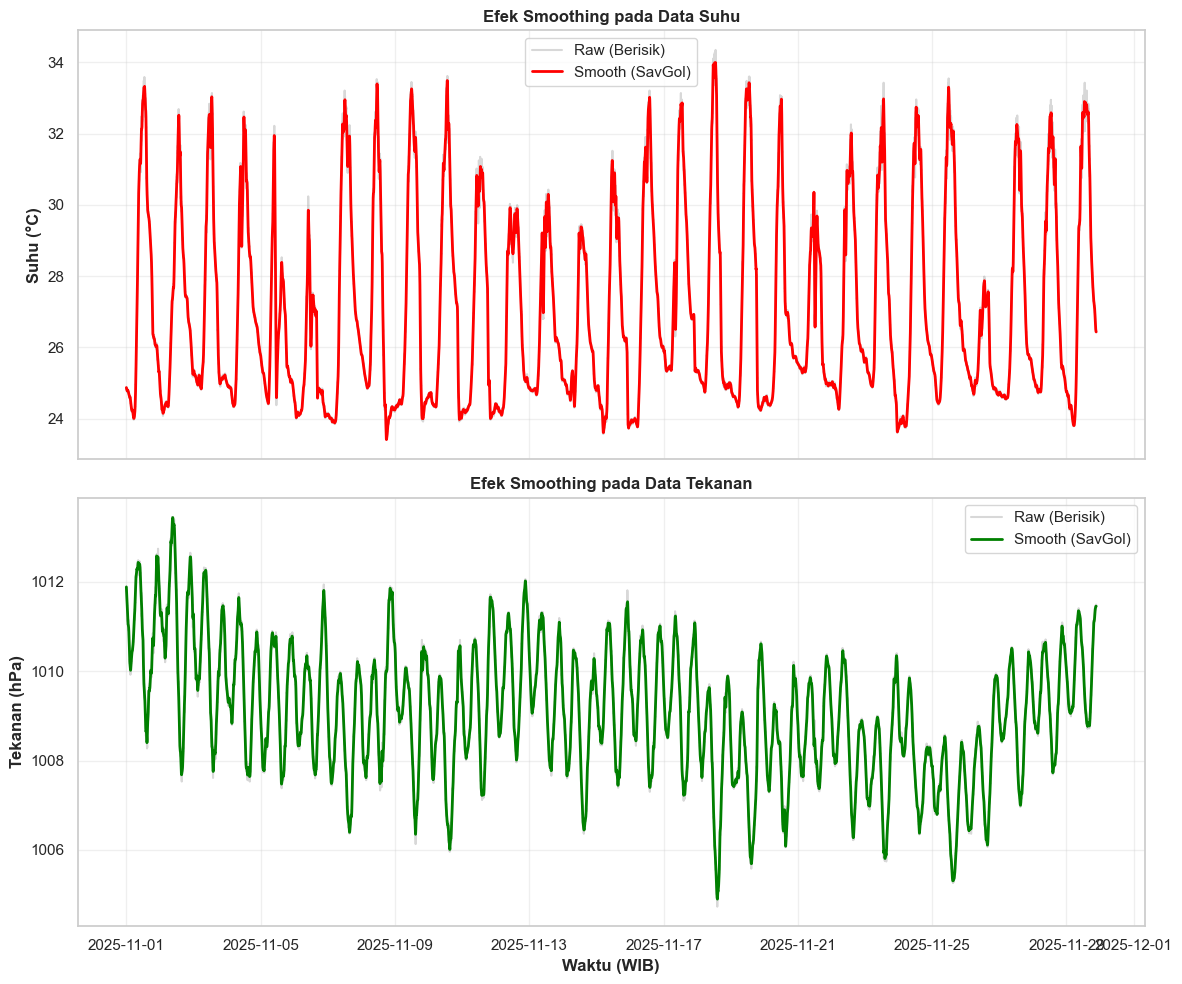

In [76]:
from scipy.signal import savgol_filter
import matplotlib.pyplot as plt
import pandas as pd

# --- 1. PERSIAPAN DATA ---
# Gunakan data_menit_utc yang sudah Anda buat sebelumnya
df_smooth = data_menit_utc.copy()

# --- 2. ISI DATA KOSONG (Prasyarat Smoothing) ---
# Algoritma smoothing matematika (seperti SavGol) TIDAK BISA bekerja jika ada NaN.
# Jadi kita harus interpolate dulu khusus untuk variabel kontinu.
cols_kontinu = ['temperature', 'humidity', 'pressure', 'dew', 'volt']

# Interpolasi 'time' agar garisnya nyambung natural sebelum dihaluskan
df_smooth[cols_kontinu] = df_smooth[cols_kontinu].interpolate(method='time')

# (Opsional) Jika masih ada NaN di awal/akhir data, gunakan bfill/ffill
df_smooth[cols_kontinu] = df_smooth[cols_kontinu].bfill().ffill()

# --- 3. PROSES SMOOTHING (SAVITZKY-GOLAY) ---
# Parameter:
# - window_length: 31 (artinya melihat jendela data 31 menit). Harus Ganjil!
# - polyorder: 3 (mengikuti bentuk kurva kubik, luwes).

for col in cols_kontinu:
    # Buat kolom baru berakhiran '_smooth'
    df_smooth[f'{col}_smooth'] = savgol_filter(df_smooth[col], window_length=61, polyorder=2)

# --- 4. CEK HASILNYA ---
print("--- Data Setelah Smoothing (UTC) ---")
print(df_smooth[['temperature', 'temperature_smooth', 'rain_mm']].tail())

# --- 5. VISUALISASI PERBANDINGAN (Raw vs Smooth) ---
# Kita convert ke WIB dulu biar enak dilihat grafiknya
df_plot = df_smooth.tz_convert('Asia/Jakarta')

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), sharex=True)

# Plot 1: Suhu (Smoothing vs Raw)
ax1.plot(df_plot.index, df_plot['temperature'], color='gray', alpha=0.3, label='Raw (Berisik)')
ax1.plot(df_plot.index, df_plot['temperature_smooth'], color='red', linewidth=2, label='Smooth (SavGol)')
ax1.set_ylabel('Suhu (°C)', fontweight='bold')
ax1.set_title('Efek Smoothing pada Data Suhu', fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Tekanan (Smoothing vs Raw)
ax2.plot(df_plot.index, df_plot['pressure'], color='gray', alpha=0.3, label='Raw (Berisik)')
ax2.plot(df_plot.index, df_plot['pressure_smooth'], color='green', linewidth=2, label='Smooth (SavGol)')
ax2.set_ylabel('Tekanan (hPa)', fontweight='bold')
ax2.set_xlabel('Waktu (WIB)', fontweight='bold')
ax2.set_title('Efek Smoothing pada Data Tekanan', fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

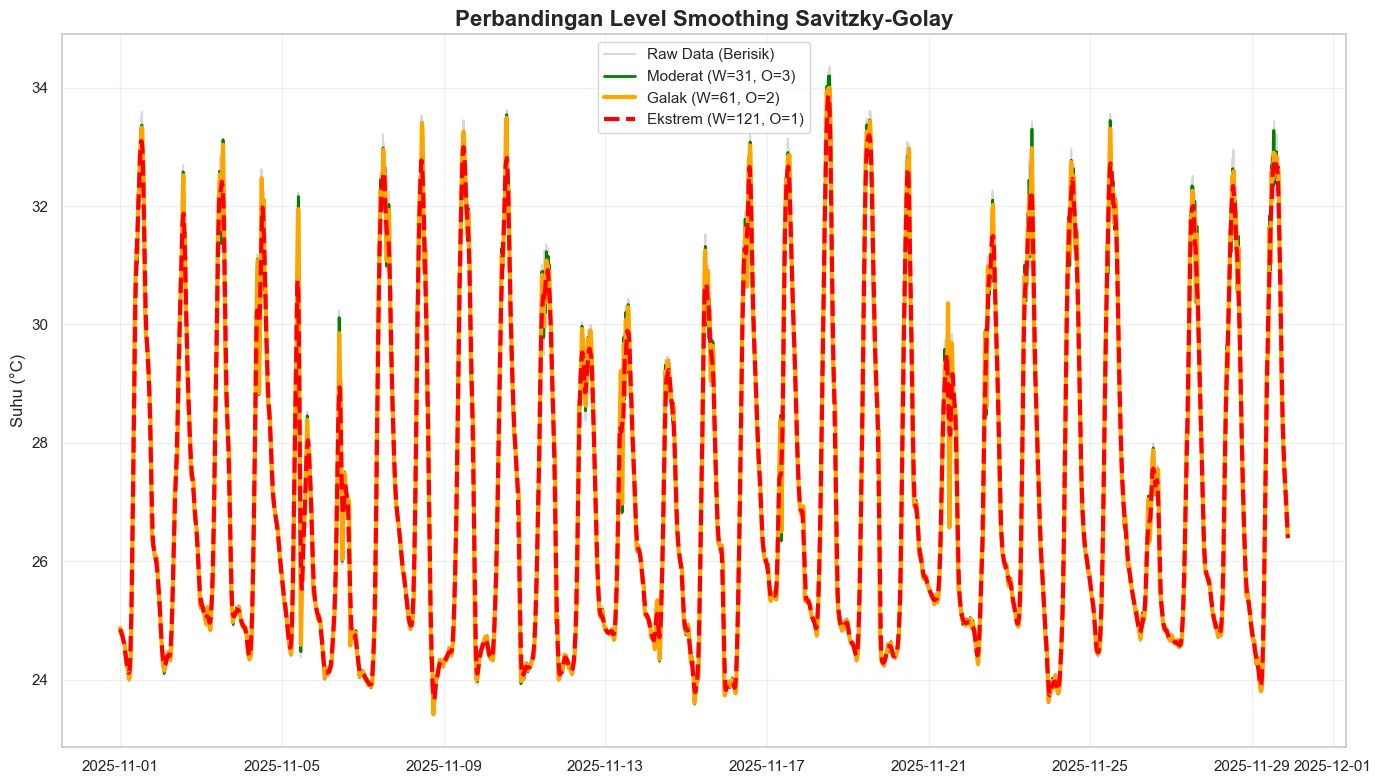

In [77]:
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter

# Asumsi: df_smooth sudah ada datanya (data_menit_utc)
# Kita fokus ke kolom Temperature saja

# --- SKENARIO 1: MODERAT (Yang Anda pakai sekarang) ---
# Window: 31 menit, Order: 3 (Masih menangkap detail kecil)
df_smooth['temp_moderate'] = savgol_filter(df_smooth['temperature'], window_length=31, polyorder=3)

# --- SKENARIO 2: GALAK (Strong) ---
# Window: 61 menit (1 Jam), Order: 2 (Lebih kaku)
df_smooth['temp_galak'] = savgol_filter(df_smooth['temperature'], window_length=61, polyorder=2)

# --- SKENARIO 3: EKSTREM (Very Strong) ---
# Window: 121 menit (2 Jam), Order: 1 (Hampir lurus)
# Ini cocok untuk melihat "Trend Harian" tanpa peduli perubahan sesaat
df_smooth['temp_ekstrem'] = savgol_filter(df_smooth['temperature'], window_length=121, polyorder=1)

# --- VISUALISASI ---
# Convert ke WIB biar enak dilihat
df_plot = df_smooth.tz_convert('Asia/Jakarta')

fig, ax = plt.subplots(figsize=(14, 8))

# 1. Data Asli (Abu-abu transparan)
ax.plot(df_plot.index, df_plot['temperature'], color='gray', alpha=0.3, label='Raw Data (Berisik)')

# 2. Moderat (Hijau)
ax.plot(df_plot.index, df_plot['temp_moderate'], color='green', linewidth=2, label='Moderat (W=31, O=3)')

# 3. Galak (Oranye)
ax.plot(df_plot.index, df_plot['temp_galak'], color='orange', linewidth=3, label='Galak (W=61, O=2)')

# 4. Ekstrem (Merah)
ax.plot(df_plot.index, df_plot['temp_ekstrem'], color='red', linewidth=3, linestyle='--', label='Ekstrem (W=121, O=1)')

ax.set_title('Perbandingan Level Smoothing Savitzky-Golay', fontsize=16, fontweight='bold')
ax.set_ylabel('Suhu (°C)', fontsize=12)
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

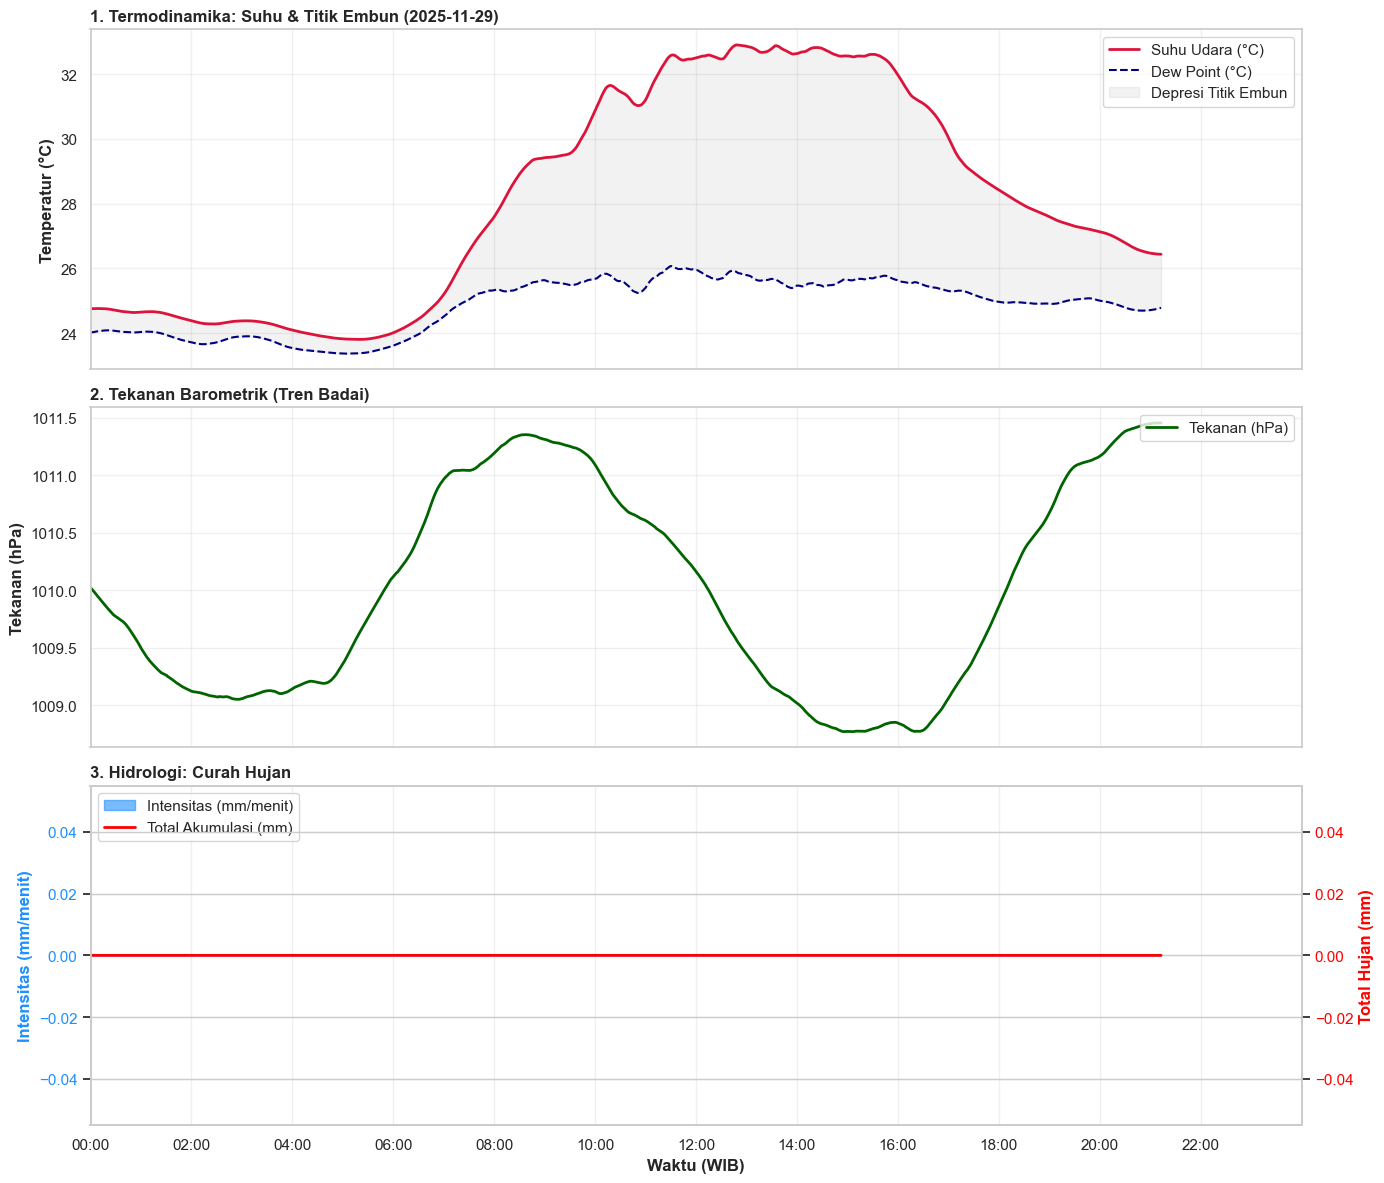

In [78]:
# --- 1. KONFIGURASI TANGGAL TARGET ---
target_date = '2025-11-29' # Ganti sesuai tanggal yang mau dicek

# --- 2. FILTER DATA ---
# Pastikan data dalam WIB
df_plot = df_smooth.tz_convert('Asia/Jakarta')

# Buat batas waktu 00:00 s.d 23:59 dengan Timezone WIB
start_time_aware = pd.Timestamp(f"{target_date} 00:00:00").tz_localize('Asia/Jakarta')
end_time_aware = pd.Timestamp(f"{target_date} 23:59:59").tz_localize('Asia/Jakarta')

# Slice data (Potong sesuai tanggal)
daily_data = df_plot.loc[start_time_aware:end_time_aware].copy()

if daily_data.empty:
    print(f"❌ Tidak ada data untuk tanggal {target_date}")
else:
    # [SOLUSI UTAMA] BUANG TIMEZONE SEBELUM PLOTTING
    # Ini memaksa jam 00:00 WIB menjadi jam 00:00 "Polos" agar grafik tidak geser
    daily_data.index = daily_data.index.tz_localize(None)
    
    # Hitung Akumulasi Harian Khusus Hari Itu (Reset dari 0)
    daily_data['rain_accum'] = daily_data['rain_mm'].cumsum()
    
    # --- 3. VISUALISASI DASHBOARD ---
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(14, 12), sharex=True)

    # ============================================================
    # PANEL 1: TERMODINAMIKA (Suhu vs Dew Point)
    # ============================================================
    # Plot Suhu (Smooth)
    ax1.plot(daily_data.index, daily_data['temperature_smooth'], 
             color='crimson', linewidth=2, label='Suhu Udara (°C)')
    
    # Plot Dew Point (Smooth)
    col_dew = 'dew_smooth' if 'dew_smooth' in daily_data.columns else 'dew'
    ax1.plot(daily_data.index, daily_data[col_dew], 
             color='navy', linestyle='--', linewidth=1.5, label='Dew Point (°C)')
    
    # Arsiran Kelembapan
    ax1.fill_between(daily_data.index, daily_data['temperature_smooth'], daily_data[col_dew], 
                     color='gray', alpha=0.1, label='Depresi Titik Embun')

    ax1.set_ylabel('Temperatur (°C)', fontweight='bold')
    ax1.set_title(f'1. Termodinamika: Suhu & Titik Embun ({target_date})', loc='left', fontweight='bold')
    ax1.legend(loc='upper right')
    ax1.grid(True, alpha=0.3)

    # ============================================================
    # PANEL 2: TEKANAN UDARA (Barometer)
    # ============================================================
    ax2.plot(daily_data.index, daily_data['pressure_smooth'], 
             color='darkgreen', linewidth=2, label='Tekanan (hPa)')
    
    ax2.set_ylabel('Tekanan (hPa)', fontweight='bold')
    ax2.set_title('2. Tekanan Barometrik (Tren Badai)', loc='left', fontweight='bold')
    
    # Highlight Tren Turun
    press_start = daily_data['pressure_smooth'].iloc[0]
    press_min = daily_data['pressure_smooth'].min()
    if (press_start - press_min) > 1.5:
        ax2.text(daily_data['pressure_smooth'].idxmin(), press_min, " DROP!", 
                 color='red', fontweight='bold', va='top')

    ax2.legend(loc='upper right')
    ax2.grid(True, alpha=0.3)

    # ============================================================
    # PANEL 3: CURAH HUJAN (Intensitas & Akumulasi)
    # ============================================================
    # Sumbu Kiri: Intensitas per Menit
    ax3.fill_between(daily_data.index, daily_data['rain_mm'], 0,
                     color='dodgerblue', alpha=0.6, label='Intensitas (mm/menit)')
    ax3.set_ylabel('Intensitas (mm/menit)', color='dodgerblue', fontweight='bold')
    ax3.tick_params(axis='y', labelcolor='dodgerblue')
    
    if daily_data['rain_mm'].max() > 0:
        ax3.set_ylim(0, daily_data['rain_mm'].max() * 3)

    # Sumbu Kanan: Total Akumulasi
    ax3_twin = ax3.twinx()
    ax3_twin.plot(daily_data.index, daily_data['rain_accum'], 
                  color='red', linewidth=2, label='Total Akumulasi (mm)')
    ax3_twin.set_ylabel('Total Hujan (mm)', color='red', fontweight='bold')
    ax3_twin.tick_params(axis='y', labelcolor='red')

    ax3.set_title('3. Hidrologi: Curah Hujan', loc='left', fontweight='bold')
    
    # Gabung Legend
    lines, labels = ax3.get_legend_handles_labels()
    lines2, labels2 = ax3_twin.get_legend_handles_labels()
    ax3.legend(lines + lines2, labels + labels2, loc='upper left')
    ax3.grid(True, alpha=0.3)

    # ============================================================
    # FINISHING TOUCH (BATAS JAM NAIVE)
    # ============================================================
    # Buat batas jam 00:00 - 23:59 TANPA TIMEZONE (Naive)
    start_limit_naive = pd.Timestamp(f"{target_date} 00:00:00")
    end_limit_naive = pd.Timestamp(f"{target_date} 23:59:59")

    # Paksa grafik menampilkan rentang ini
    ax3.set_xlim(start_limit_naive, end_limit_naive)
    
    ax3.set_xlabel('Waktu (WIB)', fontsize=12, fontweight='bold')
    ax3.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
    ax3.xaxis.set_major_locator(mdates.HourLocator(interval=2))

    plt.tight_layout()

    
    plt.show()

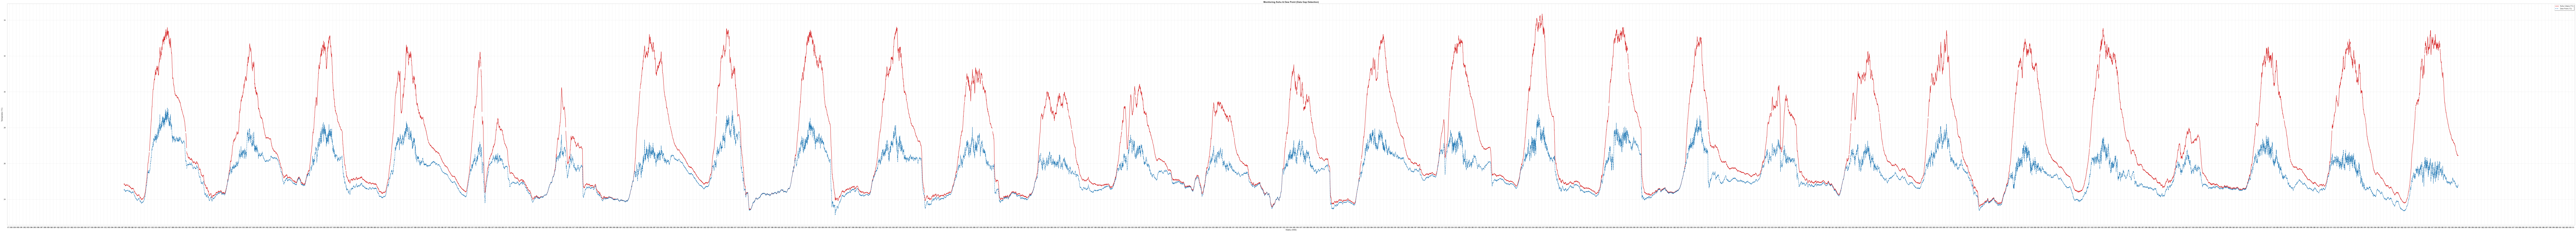

In [79]:
fig, ax = plt.subplots(figsize=(220, 20))

# 1. Plot Suhu (Garis Merah)
# Pandas/Matplotlib otomatis memutus garis jika ketemu NaN
ax.plot(data_menit_utc.index, data_menit_utc['temperature'], 
        color='tab:red', label='Suhu Udara (°C)', linewidth=2)

# 2. Plot Dew Point (Garis Biru Putus-putus)
ax.plot(data_menit_utc.index, data_menit_utc['dew'], 
        color='tab:blue', label='Dew Point (°C)', linestyle='--', linewidth=2)

# 3. Percantik Tampilan
ax.set_title('Monitoring Suhu & Dew Point (Data Gap Detection)', fontsize=14, fontweight='bold')
ax.set_ylabel('Temperatur (°C)', fontsize=12)
ax.set_xlabel('Waktu (WIB)', fontsize=12)
ax.grid(True, which='both', linestyle='--', alpha=0.6)
ax.legend(loc='upper right', frameon=True, shadow=True)

# Format Jam di Sumbu X
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax.xaxis.set_major_locator(mdates.HourLocator(interval=1)) # Label tiap jam (sesuaikan)

plt.tight_layout()
plt.show()

Menampilkan plot perbandingan per jam...


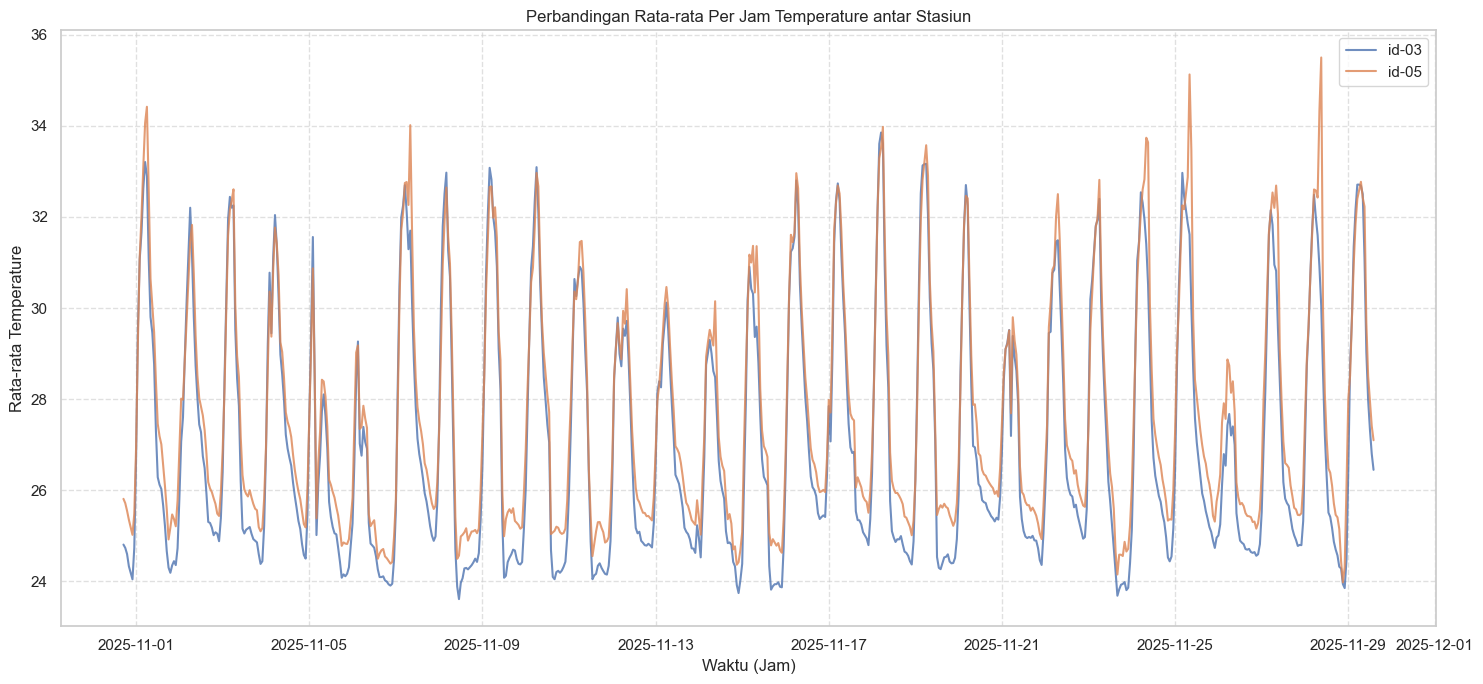

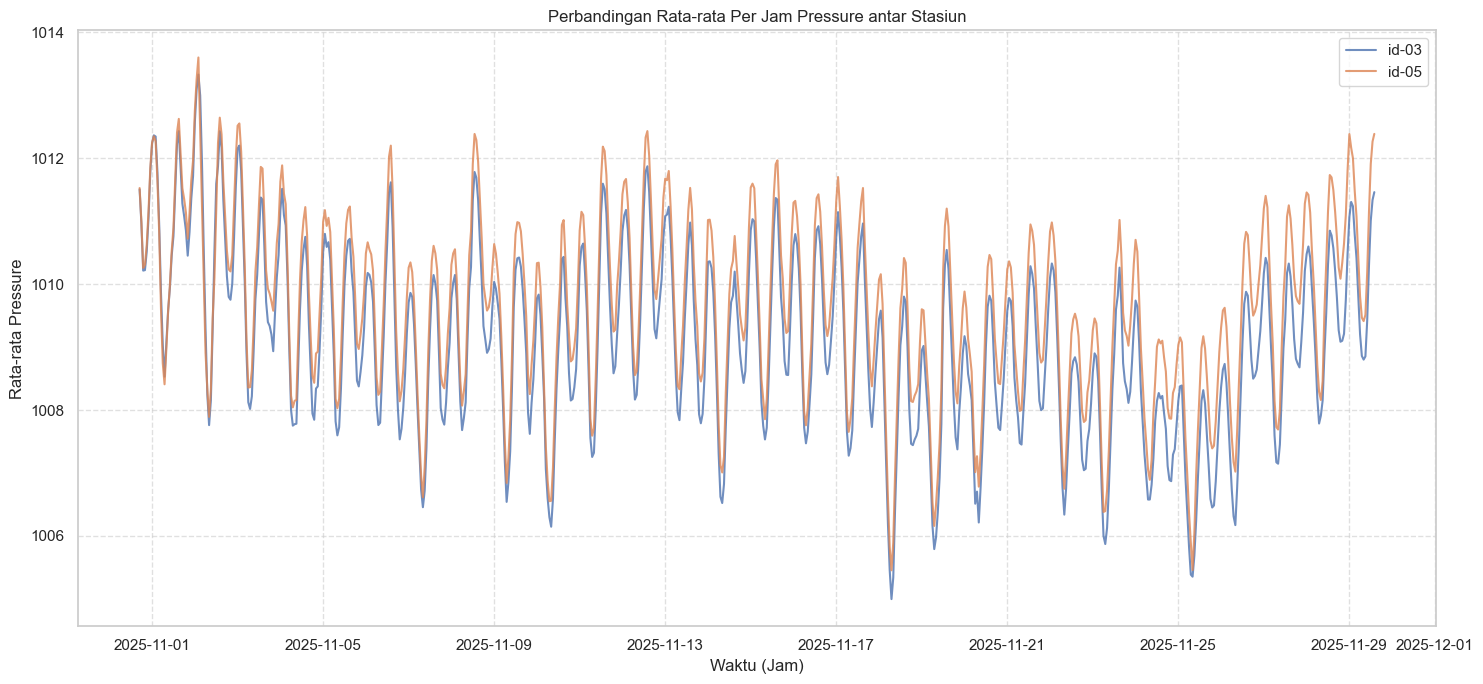

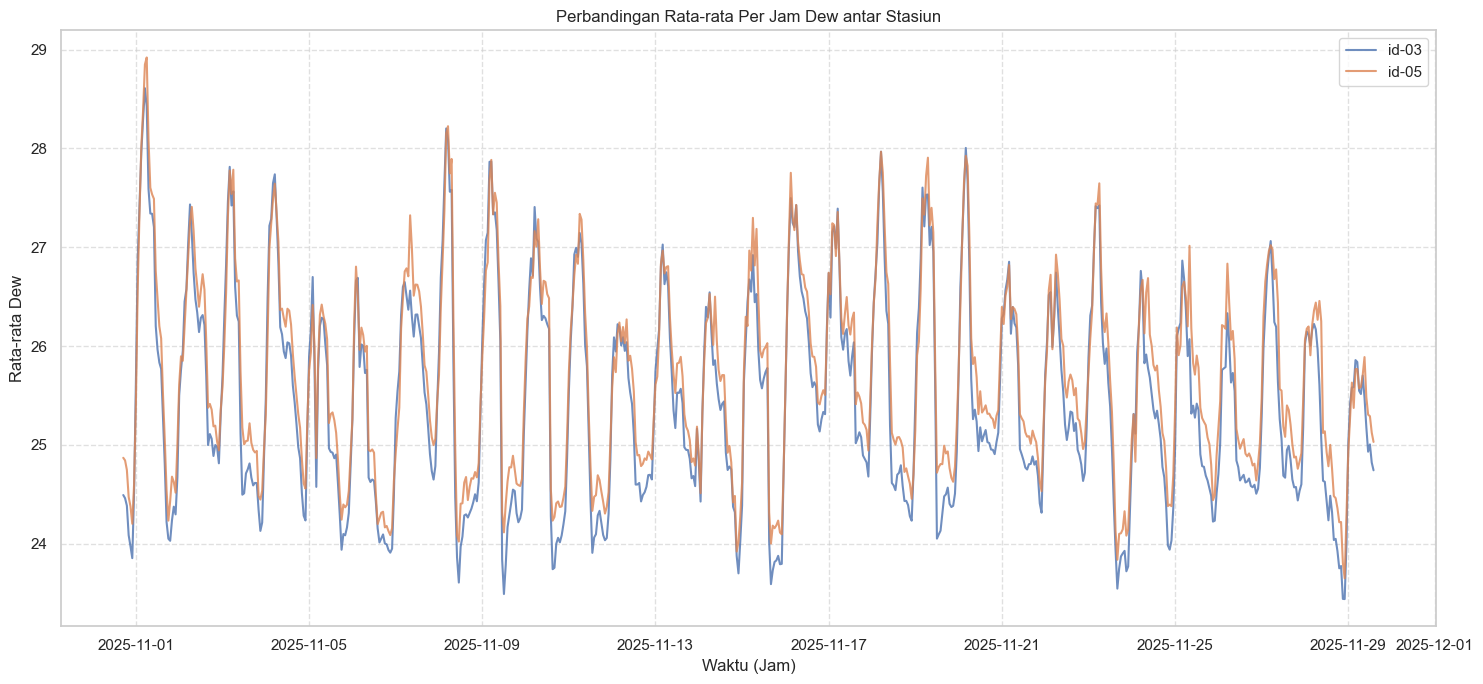

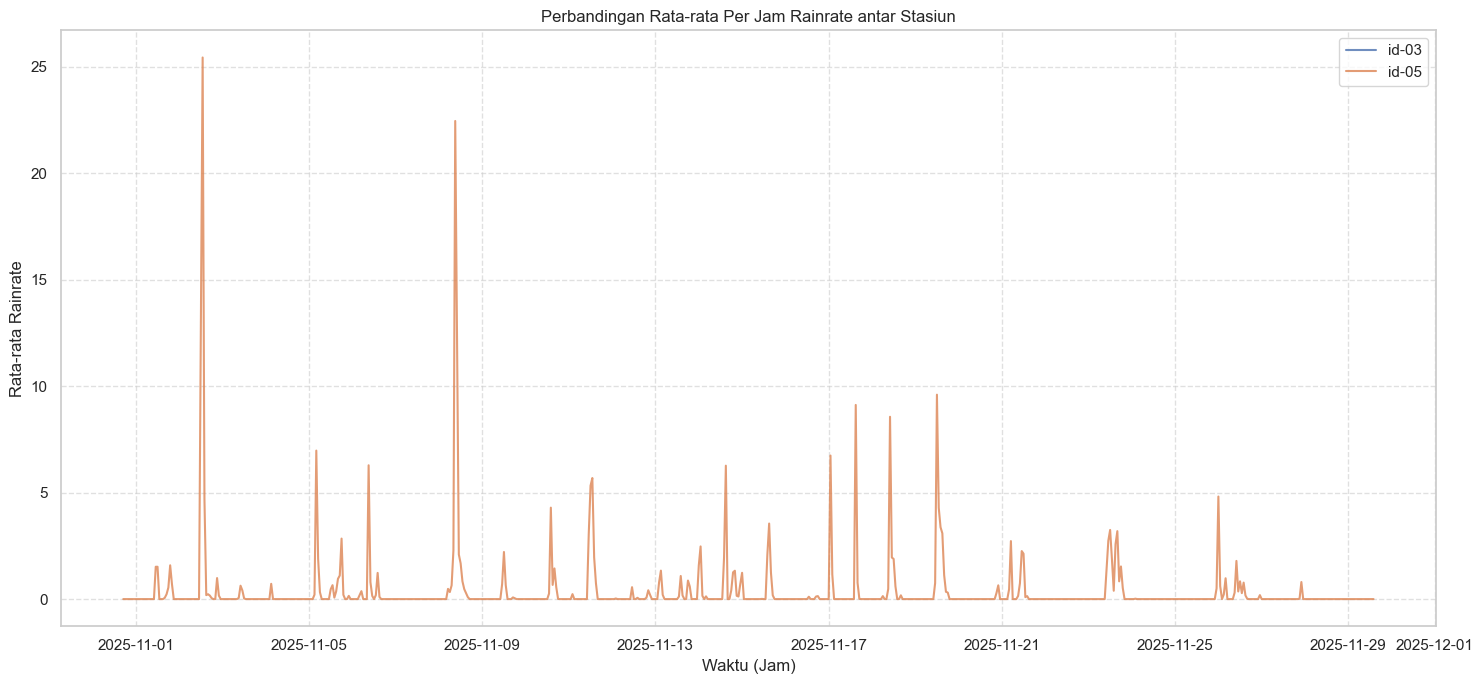


Menampilkan plot perbandingan per hari...


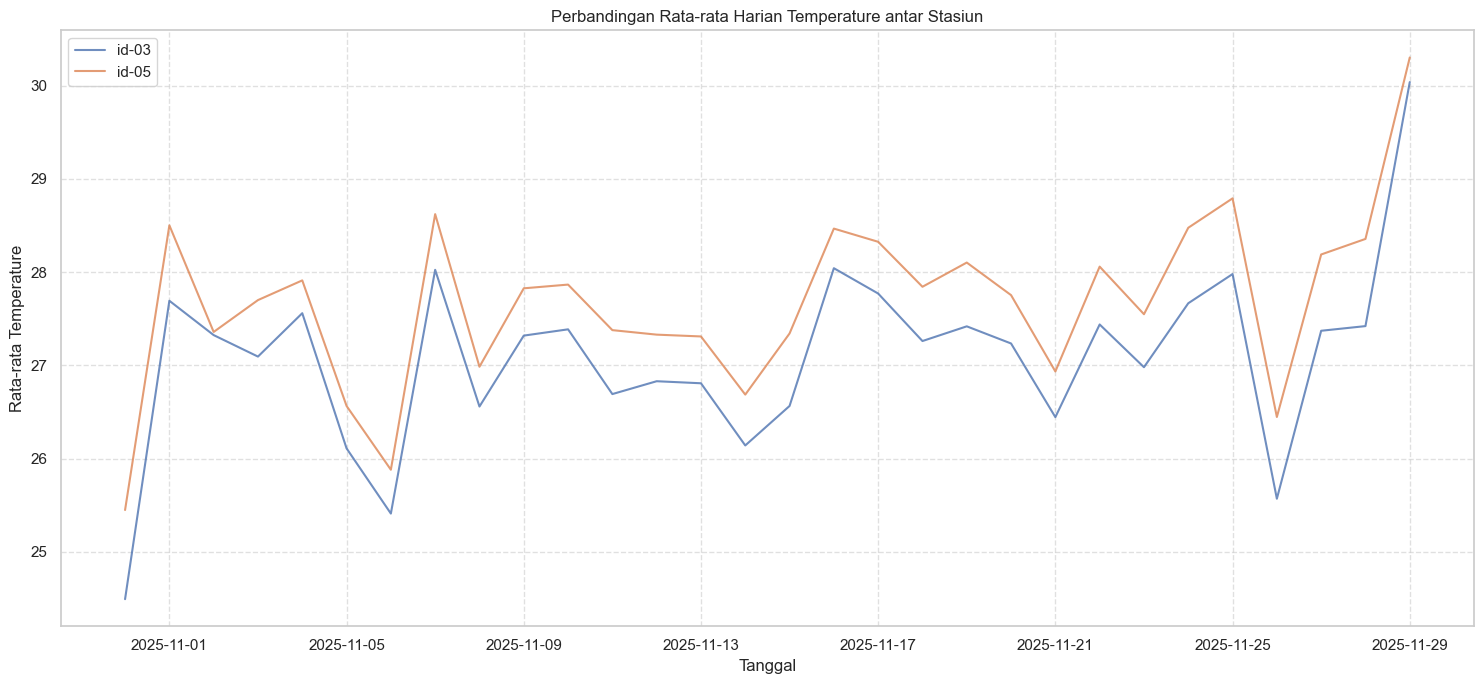

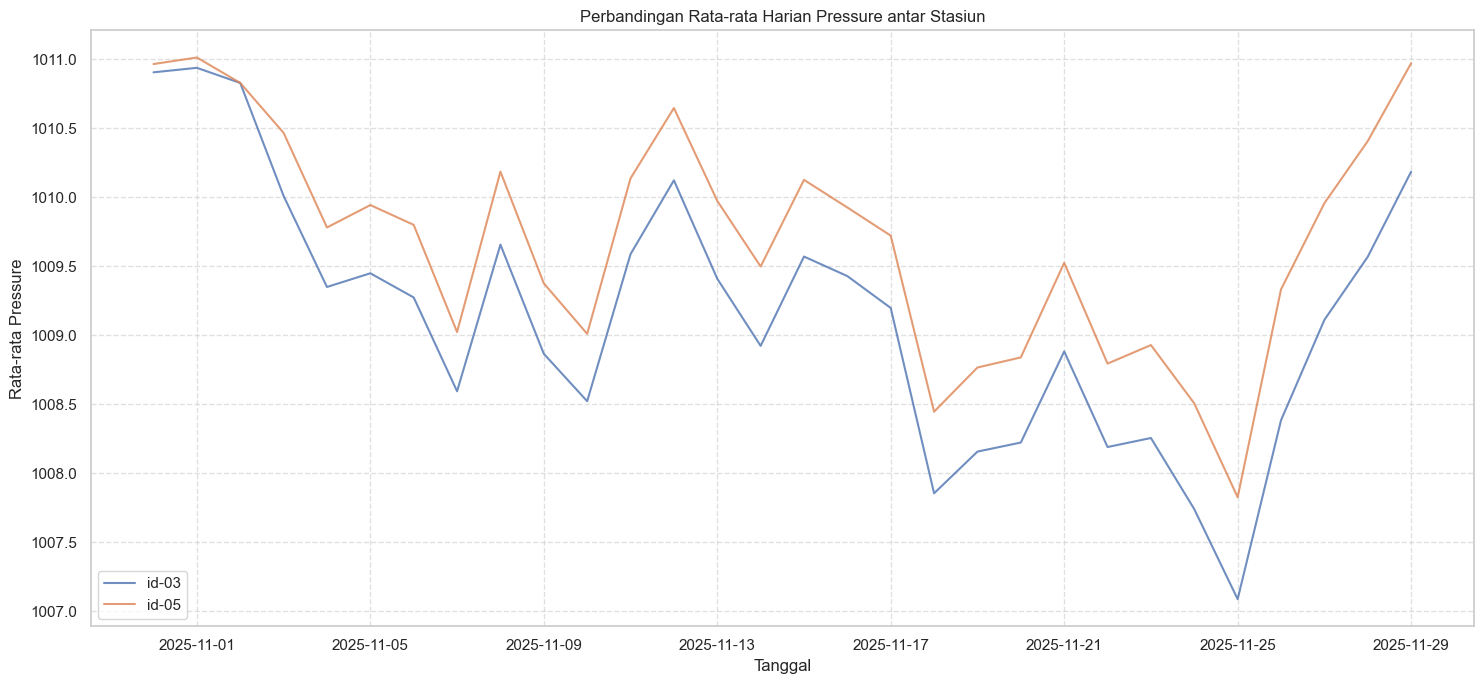

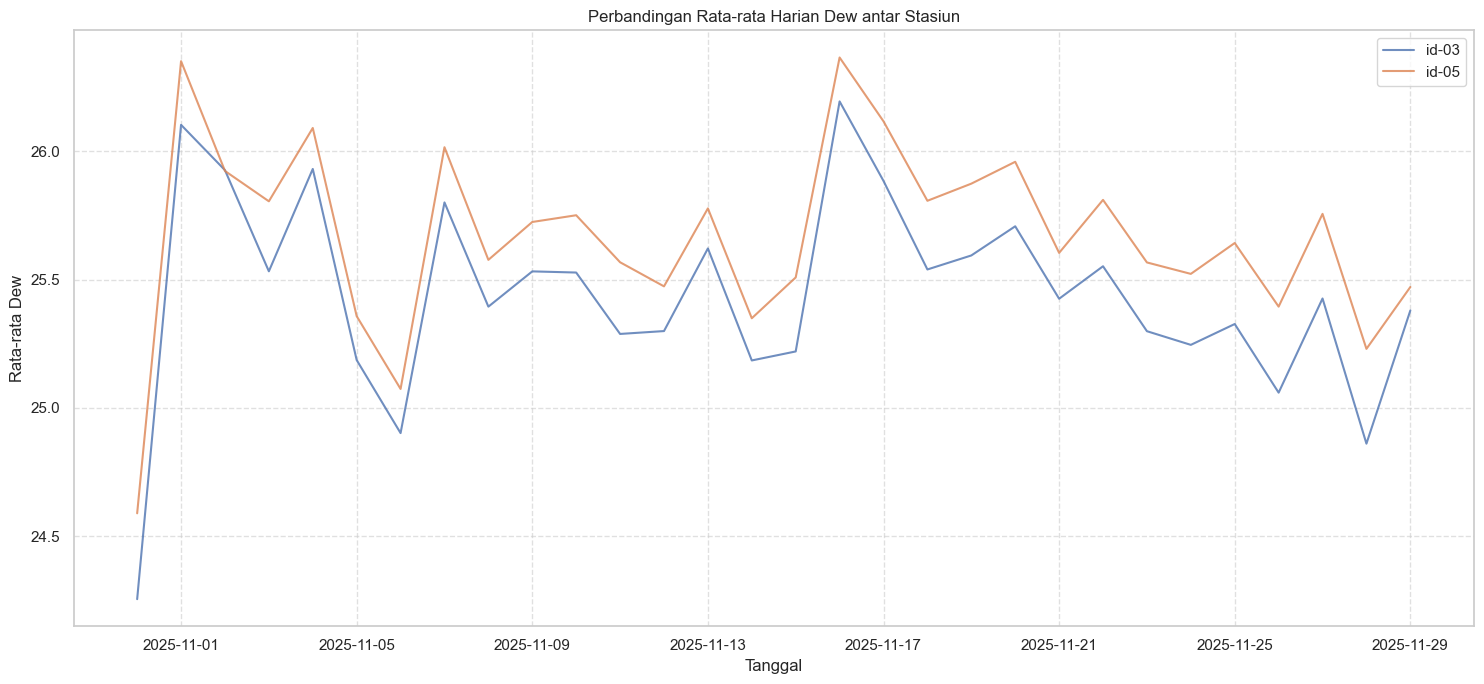

In [29]:
# Membuat Plot Rata-rata PER JAM ---
# Cukup atur freq='h'
print("Menampilkan plot perbandingan per jam...")
plot_station_trends(weather_dataframes, 'temperature', freq='h')
plot_station_trends(weather_dataframes, 'pressure', freq='h')
plot_station_trends(weather_dataframes, 'dew', freq='h')
plot_station_trends(weather_dataframes, 'rainrate', freq='h')


# Membuat Plot Rata-rata PER HARI ---
# Gunakan nilai default freq='d' atau tulis secara eksplisit
print("\nMenampilkan plot perbandingan per hari...")
plot_station_trends(weather_dataframes, 'temperature', freq='d')
plot_station_trends(weather_dataframes, 'pressure', freq='d')
plot_station_trends(weather_dataframes, 'dew', freq='d')

In [88]:

# --- 1. PERSIAPAN DATA ---
df1 = cuaca3.copy()
df2 = cuaca5.copy()
if 'timestamp' in df1.columns:
    df1['timestamp'] = pd.to_datetime(df1['timestamp'])
    df1 = df1.set_index('timestamp').sort_index()

if 'timestamp' in df2.columns:
    df2['timestamp'] = pd.to_datetime(df2['timestamp'])
    df2 = df2.set_index('timestamp').sort_index()

if df1.index.tz is None:
    df1 = df1.tz_localize('UTC')
if df2.index.tz is None:
    df2 = df2.tz_localize('UTC')

# Kita proses di UTC dulu biar aman
# (Nanti di visualisasi baru convert ke Asia/Jakarta)

# --- 2. ALGORITMA SMART RESET (Menghitung Hujan Jam-jaman) ---

# A. Pastikan urutan waktu rapat (per menit)
df_menit = df2['rainrate'].resample('1min').ffill()

# B. Hitung Selisih
delta = df_menit.diff()

# C. Logika Smart Reset (Handle Reset di tengah jam)
# Jika delta positif -> Hujan biasa
# Jika delta negatif (Reset) -> Ambil nilai saat itu
hujan_murni = np.where(delta >= 0, delta, df_menit)

# D. Masukkan ke DataFrame
df_bersih = pd.DataFrame({'hujan_mm': hujan_murni}, index=df_menit.index).fillna(0)

# E. AGREGASI KE JAM (Pakai SUM karena ini sudah tetesan murni)
jam_hujan = df_bersih['hujan_mm'].resample('h').sum()

# --- 3. PROSES SUHU (Tetap pakai Mean/Max/Min) ---
suhu_data = df1['temperature'].resample('h') # Grouping dulu
suhu_rata = suhu_data.mean()
suhu_maks = suhu_data.max()
suhu_mini = suhu_data.min()

# --- 4. GABUNGKAN JADI DATAFRAME UTAMA ---
data_meteorologi = pd.DataFrame({
    'laju_hujan': jam_hujan,  # Ini hasil Smart Reset (.sum)
    'rata_suhu': suhu_rata,
    'suhu_maks': suhu_maks,
    'suhu_mini': suhu_mini
})

# Interpolasi suhu yang bolong
data_meteorologi[['rata_suhu', 'suhu_maks', 'suhu_mini']] = \
    data_meteorologi[['rata_suhu', 'suhu_maks', 'suhu_mini']].interpolate(method='time')

print("--- Data Siap (Metode Smart Reset) ---")
print(data_meteorologi.tail(10))

--- Data Siap (Metode Smart Reset) ---
                           laju_hujan  rata_suhu  suhu_maks  suhu_mini
timestamp                                                             
2025-11-29 05:00:00+00:00         0.0  32.710000      33.42      32.11
2025-11-29 06:00:00+00:00         0.0  32.710333      33.43      32.07
2025-11-29 07:00:00+00:00         0.0  32.686833      33.21      32.34
2025-11-29 08:00:00+00:00         0.0  32.499831      32.84      31.85
2025-11-29 09:00:00+00:00         0.0  31.076500      31.80      29.97
2025-11-29 10:00:00+00:00         0.0  29.033667      29.90      28.46
2025-11-29 11:00:00+00:00         0.0  27.981864      28.43      27.62
2025-11-29 12:00:00+00:00         0.0  27.329828      27.62      27.13
2025-11-29 13:00:00+00:00         0.0  26.801833      27.13      26.45
2025-11-29 14:00:00+00:00         0.0  26.450000      26.46      26.43


In [89]:
data_meteorologi["laju_hujan"].sum()

np.float64(503.7582)

In [90]:
data_meteorologi.tail(50)

laju_hujan  rata_suhu  suhu_maks  suhu_mini
timestamp                                                             
2025-11-27 13:00:00+00:00      0.0000  25.819492      25.93      25.77
2025-11-27 14:00:00+00:00      0.0000  25.720667      25.81      25.65
2025-11-27 15:00:00+00:00      0.0000  25.661017      25.73      25.51
2025-11-27 16:00:00+00:00      0.0000  25.411333      25.55      25.28
2025-11-27 17:00:00+00:00      0.0000  25.154483      25.28      25.08
2025-11-27 18:00:00+00:00      0.0000  25.012881      25.13      24.90
2025-11-27 19:00:00+00:00      0.0000  24.912105      24.97      24.85
2025-11-27 20:00:00+00:00      0.0000  24.779310      24.88      24.70
2025-11-27 21:00:00+00:00      0.2794  24.801404      24.85      24.74
2025-11-27 22:00:00+00:00      1.3970  24.796780      24.93      24.73
2025-11-27 23:00:00+00:00      0.0000  25.325932      25.95      24.91
2025-11-28 00:00:00+00:00      0.0000  27.062542      28.19      25.99
2025-11-28 01:00:00+00:00      0.0000  28.733559      29.64      28.04
2025-11-28 02:00:00+00:00      0.0000  29.572881      30.36      29.17
2025-11-28 03:00:00+00:00      0.0000  30.775763      31.52      30.21
2025-11-28 04:00:00+00:00      0.0000  31.759483      32.38      31.24
2025-11-28 05:00:00+00:00      0.0000  32.486034      32.95      32.06
2025-11-28 06:00:00+00:00      0.0000  31.990169      32.79      31.32
2025-11-28 07:00:00+00:00      0.0000  31.596102      32.32      31.01
2025-11-28 08:00:00+00:00      0.0000  30.904576      31.55      30.39
2025-11-28 09:00:00+00:00      0.0000  30.045333      31.09      29.10
2025-11-28 10:00:00+00:00      0.0000  28.557119      29.09      27.84
2025-11-28 11:00:00+00:00      0.0000  27.213103      27.80      26.79
2025-11-28 12:00:00+00:00      0.0000  26.313051      26.79      25.77
2025-11-28 13:00:00+00:00      0.0000  25.510500      25.73      25.37
2025-11-28 14:00:00+00:00      0.0000  25.416500      25.51      25.28
2025-11-28 15:00:00+00:00      0.0000  25.177241      25.30      25.06
2025-11-28 16:00:00+00:00      0.0000  24.870667      25.07      24.74
2025-11-28 17:00:00+00:00      0.0000  24.701186      24.78      24.61
2025-11-28 18:00:00+00:00      0.0000  24.571186      24.70      24.39
2025-11-28 19:00:00+00:00      0.0000  24.323448      24.40      24.24
2025-11-28 20:00:00+00:00      0.0000  24.286271      24.40      24.10
2025-11-28 21:00:00+00:00      0.0000  23.942241      24.09      23.83
2025-11-28 22:00:00+00:00      0.0000  23.854407      24.01      23.79
2025-11-28 23:00:00+00:00      0.0000  24.482241      25.20      24.02
2025-11-29 00:00:00+00:00      0.0000  26.440678      27.63      25.27
2025-11-29 01:00:00+00:00      0.0000  28.734655      29.42      27.63
2025-11-29 02:00:00+00:00      0.0000  29.769483      30.99      29.28
2025-11-29 03:00:00+00:00      0.0000  31.341017      31.85      30.75
2025-11-29 04:00:00+00:00      0.0000  32.157759      32.82      30.96
2025-11-29 05:00:00+00:00      0.0000  32.710000      33.42      32.11
2025-11-29 06:00:00+00:00      0.0000  32.710333      33.43      32.07
2025-11-29 07:00:00+00:00      0.0000  32.686833      33.21      32.34
2025-11-29 08:00:00+00:00      0.0000  32.499831      32.84      31.85
2025-11-29 09:00:00+00:00      0.0000  31.076500      31.80      29.97
2025-11-29 10:00:00+00:00      0.0000  29.033667      29.90      28.46
2025-11-29 11:00:00+00:00      0.0000  27.981864      28.43      27.62
2025-11-29 12:00:00+00:00      0.0000  27.329828      27.62      27.13
2025-11-29 13:00:00+00:00      0.0000  26.801833      27.13      26.45
2025-11-29 14:00:00+00:00      0.0000  26.450000      26.46      26.43

In [91]:
# Langkah 1: Resample data untuk mendapatkan nilai 'rainrate' maksimum per hari.
# Langkah 2: Resample harian (cut-off 00:00 UTC / 07:00 WIB)
hujan_harian = data_meteorologi['laju_hujan'].resample('d').sum()

# Langkah 3: Hitung statistik suhu harian
# Menggunakan UTC agar sinkron dengan periode hujan
suhu_data = data_meteorologi['rata_suhu']
suhu_rata_harian = suhu_data.resample('d').mean()
suhu_maks_harian = suhu_data.resample('d').max()
suhu_mini_harian = suhu_data.resample('d').min()

# Gabungkan ke DataFrame
data_klimat = pd.DataFrame({
    'curah_hujan': hujan_harian,
    'rata_suhu': suhu_rata_harian,
    'suhu_maks': suhu_maks_harian,
    'suhu_mini': suhu_mini_harian
})

# Kembalikan index ke WIB
#data_klimat = data_klimat.tz_convert('Asia/Jakarta')

# --- FILTER TANGGAL AGAR RAPI ---
# Menggunakan start_readable_date dan end_readable_date dari input pengguna
# Format asumsi: "DD-MM-YYYY HH:MM:SS"
#start_ts = pd.to_datetime(start_readable_date, dayfirst=True).tz_localize('Asia/Jakarta').floor('D')
#end_ts = pd.to_datetime(end_readable_date, dayfirst=True).tz_localize('Asia/Jakarta').ceil('D')

# Potong data yang di luar rentang
#data_klimat = data_klimat.loc[(data_klimat.index >= start_ts) & (data_klimat.index < end_ts)]

In [92]:
data_klimat.tail(20)

curah_hujan  rata_suhu  suhu_maks  suhu_mini
timestamp                                                              
2025-11-10 00:00:00+00:00      13.9700  27.388703  33.093500  24.048814
2025-11-11 00:00:00+00:00      42.7482  26.724197  30.906610  24.049167
2025-11-12 00:00:00+00:00       5.3086  26.812589  29.793833  24.746491
2025-11-13 00:00:00+00:00      13.4112  26.807861  30.119667  24.626441
2025-11-14 00:00:00+00:00      33.8074  26.136767  29.300833  23.745000
2025-11-15 00:00:00+00:00      10.6172  26.558794  30.905833  23.820339
2025-11-16 00:00:00+00:00       1.6764  28.040750  32.800333  25.371000
2025-11-17 00:00:00+00:00      21.7932  27.775519  32.736207  24.797833
2025-11-18 00:00:00+00:00      26.2636  27.268733  33.853729  24.372333
2025-11-19 00:00:00+00:00      51.9684  27.417846  33.166667  24.270000
2025-11-20 00:00:00+00:00       1.1176  27.238588  32.701379  25.318103
2025-11-21 00:00:00+00:00      16.7640  26.448001  29.518833  24.362333
2025-11-22 00:00:00+00:00       0.0000  27.435810  31.489333  24.939153
2025-11-23 00:00:00+00:00      37.7190  26.982558  32.397333  23.686500
2025-11-24 00:00:00+00:00       0.2794  27.672251  32.541207  24.441333
2025-11-25 00:00:00+00:00       4.4704  27.996054  32.968167  24.735833
2025-11-26 00:00:00+00:00      19.2786  25.569437  27.675500  24.563390
2025-11-27 00:00:00+00:00       1.6764  27.361277  32.146667  24.779310
2025-11-28 00:00:00+00:00       0.0000  27.422734  32.486034  23.854407
2025-11-29 00:00:00+00:00       0.0000  29.848285  32.710333  26.440678

Variabel start_ts/end_ts tidak ditemukan, menampilkan semua data.
Grafik Hourly berhasil disimpan di: plots\Meteo_Chart_Hourly_id-05_2025-11-01_sd_2025-11-29.png


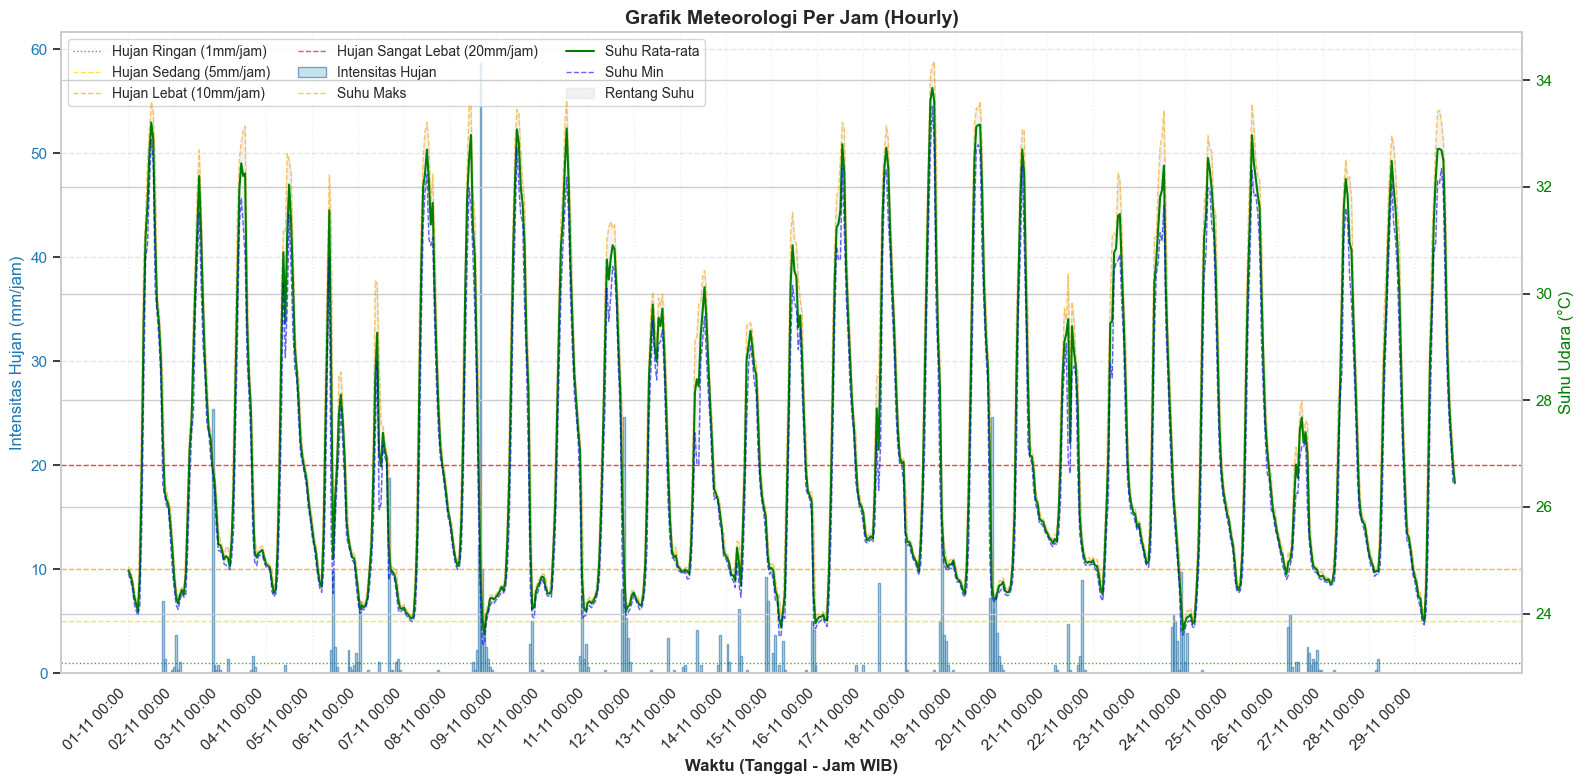

In [93]:
# --- VISUALISASI DATA PER JAM (HOURLY) ---

# 1. Persiapan Data
# Copy data agar tidak merusak variabel asli
df_plot_hourly = data_meteorologi.copy()

# Konversi ke WIB (Asia/Jakarta) agar jam sesuai dengan waktu lokal
# Cek apakah index sudah punya timezone
if df_plot_hourly.index.tz is None:
	# Jika naive, asumsikan UTC (karena output resample sebelumnya UTC) lalu convert
	df_plot_hourly = df_plot_hourly.tz_localize('UTC').tz_convert('Asia/Jakarta')
else:
	# Jika sudah aware, langsung convert
	df_plot_hourly = df_plot_hourly.tz_convert('Asia/Jakarta')

# Filter tanggal sesuai rentang yang ditentukan sebelumnya (start_ts, end_ts dari Cell 22)
# Pastikan start_ts dan end_ts ada, jika tidak skip filter
try:
	df_plot_hourly = df_plot_hourly.loc[(df_plot_hourly.index >= start_iso) & (df_plot_hourly.index < end_iso)]
except NameError:
	print("Variabel start_ts/end_ts tidak ditemukan, menampilkan semua data.")

# 2. Setup Plot
fig, ax1 = plt.subplots(figsize=(16, 8)) # Lebar diperbesar karena data per jam padat

# Buat array X-axis (angka urut) agar bar chart rapi
x_axis = range(len(df_plot_hourly))
# Buat label tanggal string untuk tick
date_labels = df_plot_hourly.index.strftime('%d-%m %H:%M')

# 3. Plot Curah Hujan (Bar chart) di ax1
# Gunakan 'laju_hujan' dari data_meteorologi
ax1.bar(x_axis, df_plot_hourly['laju_hujan'], color='lightblue', edgecolor='steelblue', label='Intensitas Hujan', alpha=0.7, width=1.0)

ax1.set_xlabel('Waktu (Tanggal - Jam WIB)', fontsize=12, fontweight='bold')
ax1.set_ylabel('Intensitas Hujan (mm/jam)', fontsize=12, color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

# Atur X-Ticks: Tampilkan label setiap 24 jam (sehari sekali) agar tidak tumpang tindih
# atau setiap 12 jam jika rentang data pendek. Kita coba setiap 24 jam.
interval_tick = 24 
ax1.set_xticks(x_axis[::interval_tick])
ax1.set_xticklabels(date_labels[::interval_tick], rotation=45, ha='right')

# Garis batas kategori hujan PER JAM (BMKG)
# Kategori intensitas hujan per jam: Ringan (1-5), Sedang (5-10), Lebat (10-20), Sangat Lebat (>20)
ax1.axhline(y=1, color='green', linestyle=':', linewidth=1, alpha=0.7, label='Hujan Ringan (1mm/jam)')
ax1.axhline(y=5, color='gold', linestyle='--', linewidth=1, alpha=0.7, label='Hujan Sedang (5mm/jam)')
ax1.axhline(y=10, color='orange', linestyle='--', linewidth=1, alpha=0.7, label='Hujan Lebat (10mm/jam)')
ax1.axhline(y=20, color='red', linestyle='--', linewidth=1, alpha=0.7, label='Hujan Sangat Lebat (20mm/jam)')

# 4. Membuat secondary y-axis (ax2) untuk Suhu
ax2 = ax1.twinx()

# A. Plot Suhu Maksimum (Jingga)
ax2.plot(x_axis, df_plot_hourly['suhu_maks'], color='orange', linestyle='--', linewidth=1, alpha=0.6, label='Suhu Maks')

# B. Plot Suhu Rata-rata (Hijau)
ax2.plot(x_axis, df_plot_hourly['rata_suhu'], color='green', linewidth=1.5, label='Suhu Rata-rata')

# C. Plot Suhu Minimum (Biru)
ax2.plot(x_axis, df_plot_hourly['suhu_mini'], color='blue', linestyle='--', linewidth=1, alpha=0.6, label='Suhu Min')

# D. Arsiran Rentang Suhu
ax2.fill_between(x_axis, df_plot_hourly['suhu_mini'], df_plot_hourly['suhu_maks'], color='gray', alpha=0.1, label='Rentang Suhu')

ax2.set_ylabel('Suhu Udara (°C)', fontsize=12, color='green')
ax2.tick_params(axis='y', labelcolor='green')

# Judul dan Grid
ax1.set_title('Grafik Meteorologi Per Jam (Hourly)', fontsize=14, fontweight='bold')
ax1.grid(axis='y', linestyle='--', alpha=0.5)
ax1.grid(axis='x', linestyle=':', alpha=0.3)

# Menggabungkan Legend
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left', bbox_to_anchor=(0, 1), ncol=3, fontsize='small', frameon=True)

plt.tight_layout()

# --- Menyimpan Plot ---
output_folder = 'plots'
if not os.path.exists(output_folder):
	os.makedirs(output_folder)

tgl_awal_str = df_plot_hourly.index[0].strftime('%Y-%m-%d')
tgl_akhir_str = df_plot_hourly.index[-1].strftime('%Y-%m-%d')
filename_hourly = f"Meteo_Chart_Hourly_id-05_{tgl_awal_str}_sd_{tgl_akhir_str}.png"
filepath_hourly = os.path.join(output_folder, filename_hourly)

plt.savefig(filepath_hourly, dpi=300)
print(f"Grafik Hourly berhasil disimpan di: {filepath_hourly}")

plt.show()


Grafik berhasil disimpan di: plots\Meteo_Chart_id-05_2025-10-31_sd_2025-11-29.png


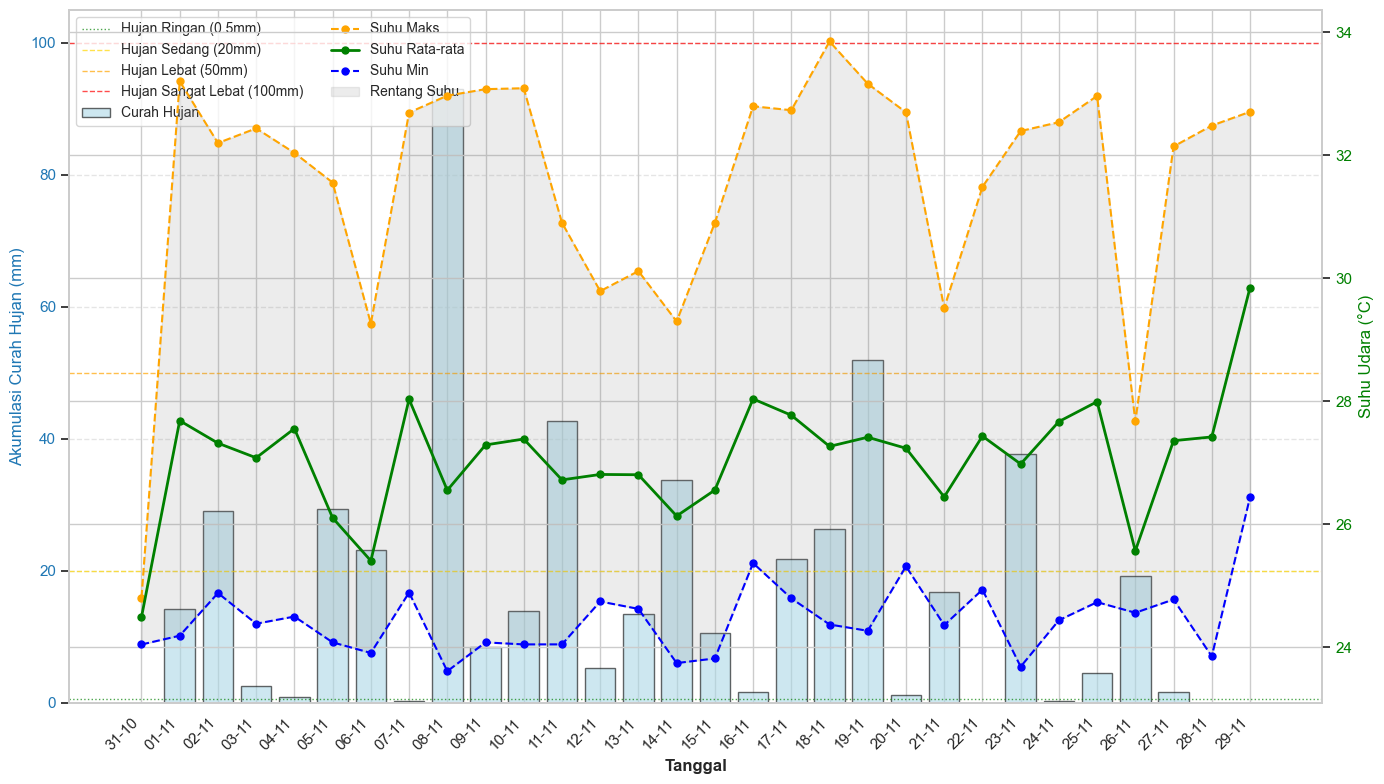

In [94]:
# --- VISUALISASI BARU ---

fig, ax1 = plt.subplots(figsize=(14, 8))

# 1. Plot Curah Hujan (Bar chart) di ax1
# Gunakan format tanggal string untuk sumbu X agar rapi
date_labels = data_klimat.index.strftime('%d-%m') 
ax1.bar(date_labels, data_klimat['curah_hujan'], color='lightblue', edgecolor='black', label='Curah Hujan', alpha=0.6)

ax1.set_xlabel('Tanggal', fontsize=12, fontweight='bold')
ax1.set_ylabel('Akumulasi Curah Hujan (mm)', fontsize=12, color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

# Memiringkan label tanggal agar tidak tumpang tindih
plt.xticks(rotation=45, ha='right')

# Garis batas kategori hujan (BMKG)
ax1.axhline(y=0.5, color='green', linestyle=':', linewidth=1, alpha=0.7, label='Hujan Ringan (0.5mm)')
ax1.axhline(y=20, color='gold', linestyle='--', linewidth=1, alpha=0.7, label='Hujan Sedang (20mm)')
ax1.axhline(y=50, color='orange', linestyle='--', linewidth=1, alpha=0.7, label='Hujan Lebat (50mm)')
ax1.axhline(y=100, color='red', linestyle='--', linewidth=1, alpha=0.7, label='Hujan Sangat Lebat (100mm)')

# 2. Membuat secondary y-axis (ax2) untuk Suhu
ax2 = ax1.twinx()

# Kita plot garis menggunakan range(len) agar pas di tengah bar chart
x_axis = range(len(data_klimat))

# A. Plot Suhu Maksimum (Jingga)
ax2.plot(x_axis, data_klimat['suhu_maks'], color='orange', linestyle='--', marker='o', markersize=5, label='Suhu Maks')

# B. Plot Suhu Rata-rata (Hijau)
ax2.plot(x_axis, data_klimat['rata_suhu'], color='green', linewidth=2, marker='o', markersize=5, label='Suhu Rata-rata')

# C. Plot Suhu Minimum (Biru)
ax2.plot(x_axis, data_klimat['suhu_mini'], color='blue', linestyle='--', marker='o', markersize=5, label='Suhu Min')

# D. Arsiran Rentang Suhu (Diurnal Range) - Opsional tapi Bagus
# Memberikan efek visual rentang suhu hari itu
ax2.fill_between(x_axis, data_klimat['suhu_mini'], data_klimat['suhu_maks'], color='gray', alpha=0.15, label='Rentang Suhu')
ax2.set_ylabel('Suhu Udara (°C)', fontsize=12, color='green')
ax2.tick_params(axis='y', labelcolor='green')

# Judul dan Grid
ax1.grid(axis='y', linestyle='--', alpha=0.5)

# Menggabungkan Legend dari kedua axis agar rapi
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
# Taruh legend di luar plot atau di posisi kosong
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left', bbox_to_anchor=(0, 1), ncol=2, fontsize='small', frameon=True)

plt.tight_layout()

# --- Menyimpan Plot ---
output_folder = 'plots'
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# Ambil tanggal awal dan akhir dari index dataframe langsung (lebih aman)
tgl_awal = data_klimat.index[0].strftime('%Y-%m-%d')
tgl_akhir = data_klimat.index[-1].strftime('%Y-%m-%d')
filename = f"Meteo_Chart_id-05_{tgl_awal}_sd_{tgl_akhir}.png"
filepath = os.path.join(output_folder, filename)

plt.savefig(filepath, dpi=300)
print(f"Grafik berhasil disimpan di: {filepath}")

plt.show()

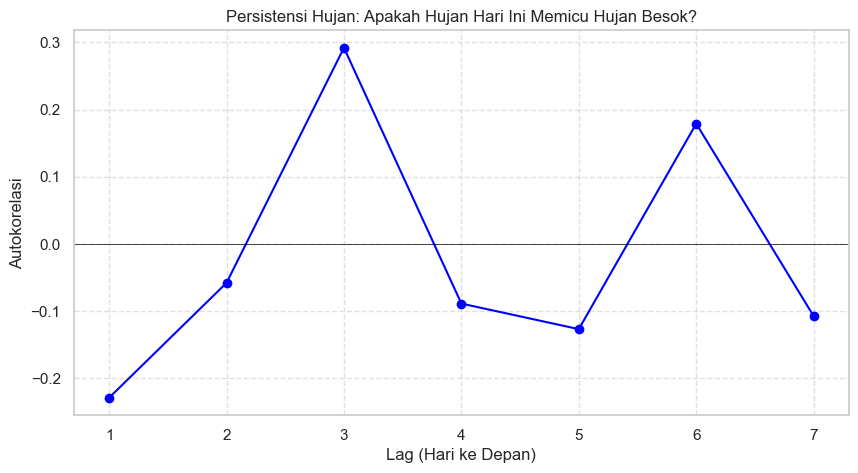

In [95]:
hasil_autokorelasi = []
max_lag = 7

for i in range(1, max_lag + 1):
    # Hujan Hari Ini vs Hujan Masa Depan
    future_rain = data_klimat['curah_hujan'].shift(-i)
    
    # Korelasi Hujan vs Hujan
    corr = data_klimat['curah_hujan'].corr(future_rain)
    hasil_autokorelasi.append(corr)
    
plt.figure(figsize=(10, 5))
plt.plot(range(1, max_lag + 1), hasil_autokorelasi, marker='o', color='blue')
plt.axhline(0, color='black', linewidth=0.5)
plt.xlabel('Lag (Hari ke Depan)')
plt.ylabel('Autokorelasi')
plt.title('Persistensi Hujan: Apakah Hujan Hari Ini Memicu Hujan Besok?')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

Text(0.5, 0, 'Lama Hujan (Jam)')

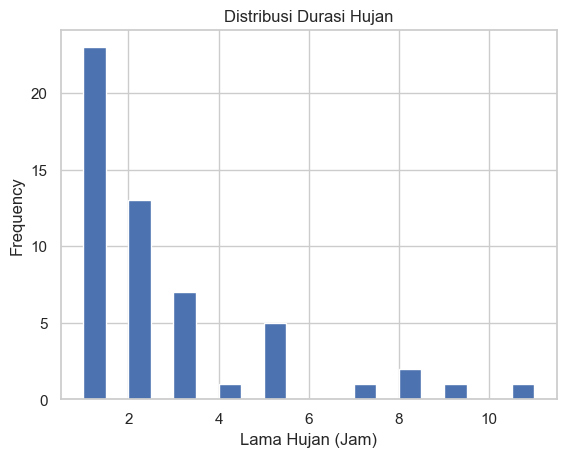

In [96]:
# Logika untuk mengelompokkan jam hujan berturut-turut
# (Kode agak kompleks, ini logika intinya)
data_meteorologi['is_rain'] = data_meteorologi['laju_hujan'] > 0
# Memberi ID unik untuk setiap blok kejadian hujan
data_meteorologi['storm_id'] = (data_meteorologi['is_rain'] != data_meteorologi['is_rain'].shift()).cumsum()

# Filter hanya yang hujan
badai = data_meteorologi[data_meteorologi['is_rain']].groupby('storm_id')

# Hitung durasi setiap badai
durasi_badai = badai.size()  # Dalam jam (karena data per jam)

# Histogram Durasi
durasi_badai.plot(kind='hist', bins=20, title='Distribusi Durasi Hujan')
plt.xlabel('Lama Hujan (Jam)')

Total Data Harian: 30 hari
Jumlah Hari Hujan: 24
Jumlah Hari Kering: 6

Matriks Kejadian (Count):
[[ 1.  4.]
 [ 4. 20.]]


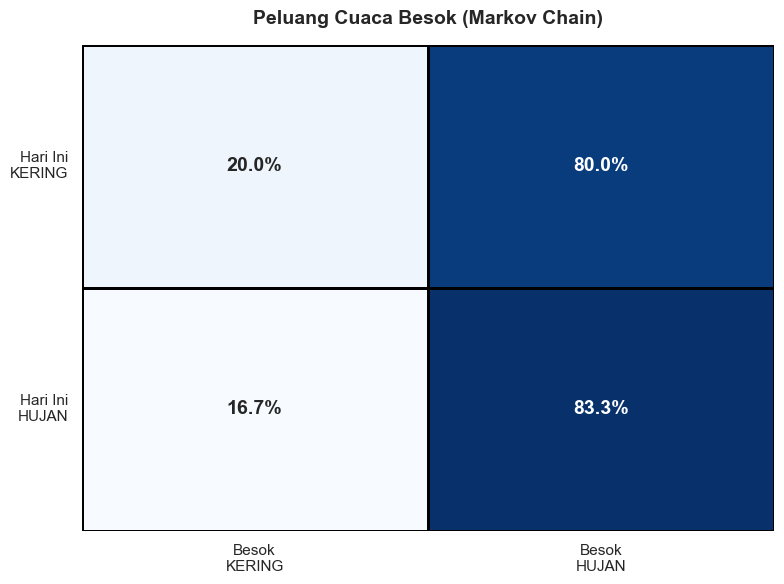

In [97]:
# --- 1. PERSIAPAN DATA ---
# Gunakan threshold 0.5 mm agar lebih valid secara meteorologis
threshold_hujan = 0.5
status_hujan = data_klimat['curah_hujan'].apply(lambda x: 1 if x >= threshold_hujan else 0).values

print(f"Total Data Harian: {len(status_hujan)} hari")
print(f"Jumlah Hari Hujan: {np.sum(status_hujan)}")
print(f"Jumlah Hari Kering: {len(status_hujan) - np.sum(status_hujan)}")

# --- 2. HITUNG TRANSISI (MANUAL) ---
jumlah_transisi = np.zeros((2, 2)) 

for t in range(len(status_hujan) - 1):
    state_sekarang = status_hujan[t]      
    state_besok    = status_hujan[t + 1]  
    jumlah_transisi[state_sekarang][state_besok] += 1

print("\nMatriks Kejadian (Count):")
print(jumlah_transisi)

# --- 3. HITUNG PROBABILITAS ---
matriks_probabilitas = np.zeros((2, 2))
total_per_state = jumlah_transisi.sum(axis=1)

for i in range(2):
    if total_per_state[i] > 0: # Mencegah bagi dengan nol
        for j in range(2):
            matriks_probabilitas[i][j] = jumlah_transisi[i][j] / total_per_state[i]

# --- 4. VISUALISASI ---
df_plot = pd.DataFrame(matriks_probabilitas, 
                       index=['Hari Ini\nKERING', 'Hari Ini\nHUJAN'],
                       columns=['Besok\nKERING', 'Besok\nHUJAN'])

plt.figure(figsize=(8, 6))
sns.heatmap(df_plot, 
            annot=True, 
            fmt=".1%", # 1 desimal cukup (contoh: 58.3%)
            cmap="Blues", 
            linewidths=1, 
            linecolor='black',
            cbar=False, # Hilangkan colorbar biar simpel
            annot_kws={"size": 14, "weight": "bold"})

plt.title('Peluang Cuaca Besok (Markov Chain)', fontsize=14, fontweight='bold', pad=15)
plt.yticks(rotation=0) 
plt.tight_layout()
plt.show()

--- Statistik Diurnal (WIB) ---
     Total Intensitas  Frekuensi
jam                             
0              5.5880          8
1             19.5580          6
2              5.5880          4
3              1.9558          2
4              3.3528          4


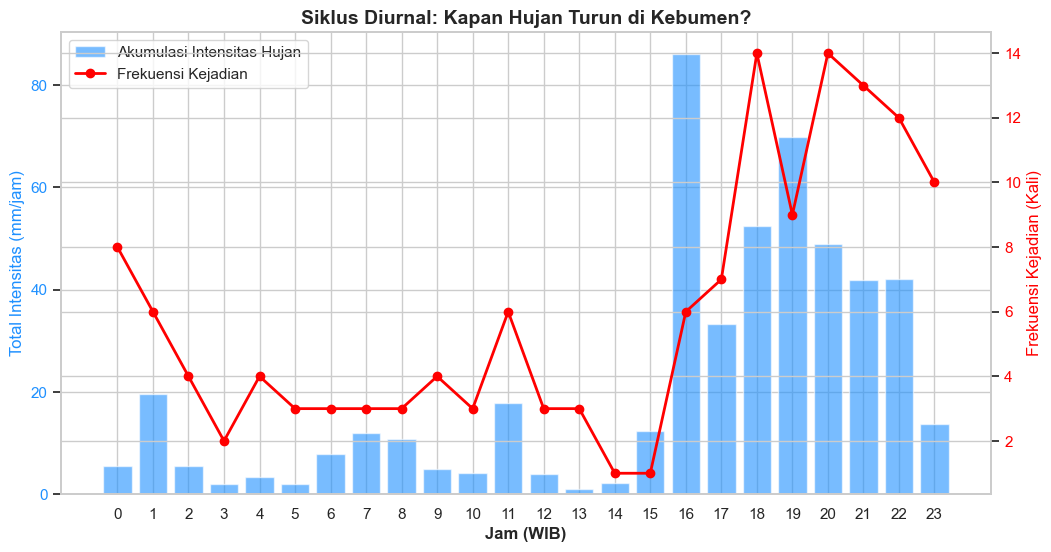

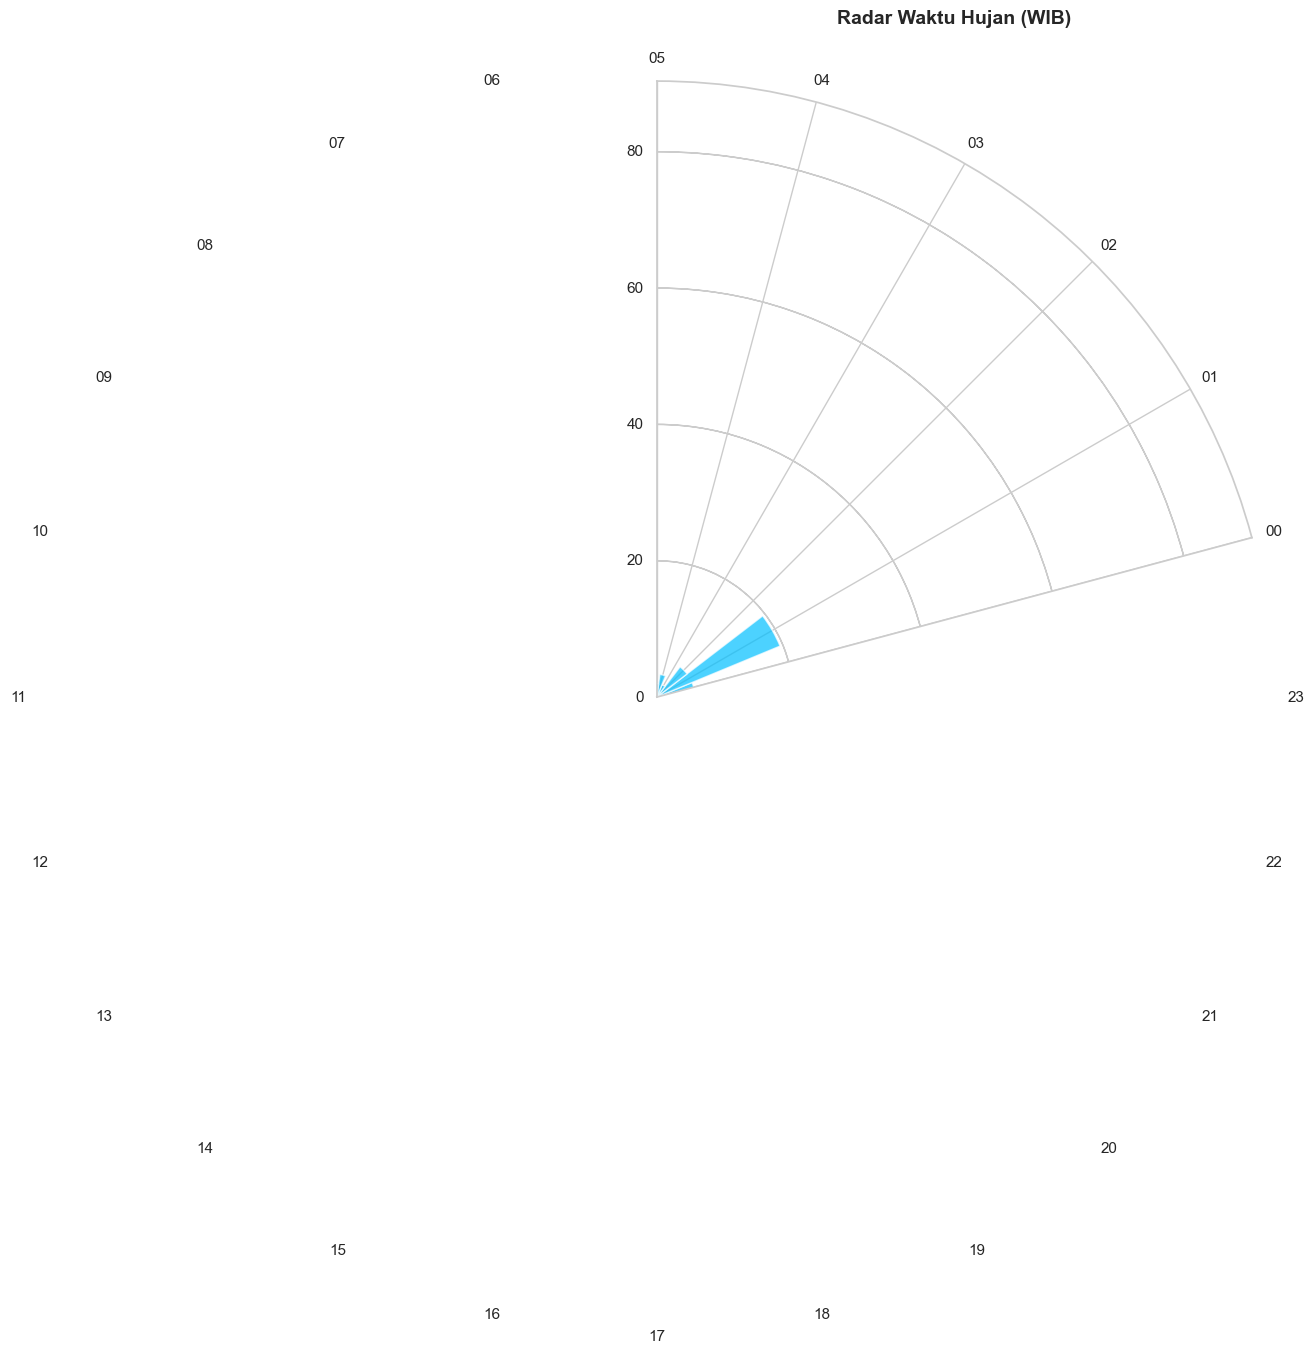

In [98]:
# --- 1. PERSIAPAN DATA ---
# Kita copy dataframe Anda agar data asli aman
df_analisis = data_meteorologi.copy()

# [PENTING] Kembalikan ke WIB (Asia/Jakarta) untuk analisis jam
# Karena pola aktivitas manusia dan matahari mengikuti waktu lokal
df_analisis = df_analisis.tz_convert('Asia/Jakarta')

# Ekstrak jam (0-23) dari index
df_analisis['jam'] = df_analisis.index.hour

# --- 2. HITUNG STATISTIK PER JAM ---

# A. Total Intensitas (Akumulasi 'laju_hujan')
# Menjawab: "Di jam berapa hujan biasanya paling deras?"
# Karena 'laju_hujan' Anda adalah nilai MAX per jam, menjumlahkannya 
# akan menunjukkan jam mana yang sering mendapat intensitas tinggi.
hourly_intensity = df_analisis.groupby('jam')['laju_hujan'].sum()

# B. Frekuensi Kejadian (Peluang)
# Menjawab: "Di jam berapa paling sering terjadi hujan?"
# Kita filter jam dimana laju_hujan > 0.2 (bukan noise)
jam_basah = df_analisis[df_analisis['laju_hujan'] > 0.2]
hourly_freq = jam_basah.groupby('jam')['laju_hujan'].count()

# Gabungkan data (isi 0 jika tidak ada hujan)
df_stats = pd.DataFrame({
    'Total Intensitas': hourly_intensity,
    'Frekuensi': hourly_freq
}).fillna(0)

print("--- Statistik Diurnal (WIB) ---")
print(df_stats.head())

# --- 3. VISUALISASI 1: GRAFIK KOMBO (Bar & Line) ---

fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot Batang (Intensitas)
ax1.bar(df_stats.index, df_stats['Total Intensitas'], color='dodgerblue', alpha=0.6, label='Akumulasi Intensitas Hujan')
ax1.set_xlabel('Jam (WIB)', fontsize=12, fontweight='bold')
ax1.set_ylabel('Total Intensitas (mm/jam)', color='dodgerblue', fontsize=12)
ax1.tick_params(axis='y', labelcolor='dodgerblue')
ax1.set_xticks(range(0, 24)) 

# Plot Garis (Frekuensi)
ax2 = ax1.twinx()
ax2.plot(df_stats.index, df_stats['Frekuensi'], color='red', marker='o', linewidth=2, label='Frekuensi Kejadian')
ax2.set_ylabel('Frekuensi Kejadian (Kali)', color='red', fontsize=12)
ax2.tick_params(axis='y', labelcolor='red')

plt.title('Siklus Diurnal: Kapan Hujan Turun di Kebumen?', fontsize=14, fontweight='bold')
plt.grid(axis='x', linestyle='--', alpha=0.5)

# Gabung Legend
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

plt.show()

# --- 4. VISUALISASI 2: POLAR PLOT (Jam Dinding) ---

# Setup sudut lingkaran (Jam 0-23)
theta = np.linspace(0.0, 2 * np.pi, 24, endpoint=False)
# Geser agar jam 00:00 ada di Atas (Utara), bukan Kanan
theta = theta + np.pi/2 
# Putar arah jarum jam (bukan matematis berlawanan arah)
theta = theta[::-1] 
width = (2*np.pi) / 24

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='polar')

# Plot Data
bars = ax.bar(theta, df_stats['Total Intensitas'], width=width, bottom=0.0, 
              color='deepskyblue', alpha=0.7, edgecolor='white')

# Label Jam
ax.set_theta_zero_location("N")
ax.set_theta_direction(-1)
ax.set_xticks(theta)
ax.set_xticklabels([f"{h:02d}" for h in range(24)])

plt.title("Radar Waktu Hujan (WIB)", fontsize=14, fontweight='bold', pad=20)
plt.show()

In [99]:
data_klimat.describe()

curah_hujan  rata_suhu  suhu_maks  suhu_mini
count    30.000000  30.000000  30.000000  30.000000
mean     16.791940  27.081657  31.586329  24.451789
std      20.489409   0.970272   1.961198   0.596831
min       0.000000  24.493003  24.809322  23.612881
25%       1.257300  26.600145  30.906028  24.048902
50%      12.014200  27.280581  32.419250  24.378667
75%      25.495250  27.527627  32.784302  24.771106
max      93.040200  29.848285  33.853729  26.440678

In [100]:
data_meteorologi.describe()

laju_hujan   rata_suhu   suhu_maks   suhu_mini    storm_id
count  694.000000  694.000000  694.000000  694.000000  694.000000
mean     0.725876   27.109189   27.522983   26.708386   59.579251
std      3.255064    2.688083    2.898691    2.480097   35.824511
min      0.000000   23.612881   23.750000   23.430000    1.000000
25%      0.000000   24.873975   25.012500   24.740000   27.000000
50%      0.000000   26.183792   26.555000   25.775000   67.000000
75%      0.000000   29.102881   29.757500   28.540000   95.000000
max     58.674000   33.853729   34.350000   33.510000  109.000000

In [101]:
data_meteorologi['laju_hujan'].sum()

np.float64(503.7582)

In [102]:
data_klimat['curah_hujan'].sum()

np.float64(503.75819999999993)